# Physics Informed Neural Network
Physics Informed Neural Networks (PINNs) are a class of deep learning models that incorporate physical laws, typically expressed as partial differential equations (PDEs), into the training process. By embedding these equations into the loss function, PINNs enable neural networks to learn solutions that are consistent with known physics, even when data is scarce or noisy. This approach is particularly useful for solving forward and inverse problems in science, where traditional numerical methods may be computationally expensive or limited by incomplete information.

To solve a PDE you need (i) a domain (D) definition, (ii) an initial (or constrined) condition (IC), and (iii) boundary condition (BC). These requirements define a boundary value problem (BVP).
Since the aim in a PINN experiment is to find an approximate solution to a BVP, the inputs to these networks are spatiotemporal coordinates and the outputs are the solution values at those points and times.\
During training, we can distinguish a supervised component — the data-driven part (e.g., experimental data embedded in the IC) — and an unsupervised component — the equation-driven part provided by the PDE and the BC.

In this exercise we implement a PINN for a simple BVP that admits an analytic solution. This will provide the fundamental tools used subsequently for more complex problems.

**NB:** No specific Python library is suggested. Students should write the code using whichever libraries they prefer.

## BVP to solve
For simplicity (and to not spoil the fun of trying to do better), we choose the 1D heat equation:

$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}, \qquad x \in [0,L],\ t \in [0,T]$

IC: $u(x,0) = \sin\!\left(\frac{\pi x}{L}\right)$

BC: $u(0,t) = u(L,t) = 0 \quad \forall t > 0$

The analytical solution is:

$u(x,t) = \sin\!\left(\frac{\pi x}{L}\right) \exp\!\left(-\frac{\pi^2 D}{L^2} t\right)$

## ✅ Solution Validation

This is the complete solution notebook. You can run the test suite at any point to validate the implementation:

- After each major section (Geometry, PINN, Loss Functions)
- Or run all tests comprehensively before training

The test suite is in `test_pinn.py` and will validate all implementations.

---

In [1]:
from test_pinn import run_all_tests

## 1. Domain definition

To solve this equation using a PINN model, you need to define the computational domain and sample points from it.

**Task 1.1:** Create a Python `Class` called `Geometry` with the following specifications:

**Initialization:**
- Input: geometric and topological information of the domain (spatial domain `[0, L]`, temporal domain `[t_start, t_end]`)
- Store these parameters for later use

**Required Methods:**

1. **Method `sample_interior(N1)`** - Sample interior domain points
   - Input: `N1` (integer) - number of points to sample
   - Output: Array of shape `(N1, 2)` containing random `(x, t)` pairs where `x ∈ (0, L)` and `t ∈ (t_start, t_end)`
   - Note: Boundary points should be excluded (i.e., `x ≠ 0` and `x ≠ L`)

2. **Method `sample_boundary(N2)`** - Sample boundary points
   - Input: `N2` (integer) - number of points to sample
   - Output: Array of shape `(N2, 2)` containing random `(x, t)` pairs where `x ∈ {0, L}` and `t ∈ (t_start, t_end)`
   - Note: These points should be at the spatial boundaries only

3. **Method `sample_initial(N3)`** - Sample initial condition points
   - Input: `N3` (integer) - number of points to sample
   - Output: Array of shape `(N3, 2)` containing random `(x, 0)` pairs where `x ∈ [0, L]` and `t = 0`
   - Note: These points are for enforcing the initial condition

4. **Method `sample_at_time(N4, t1)`** (Optional but recommended)
   - Input: `N4` (integer) - number of points, `t1` (float) - specific time
   - Output: Array of shape `(N4, 2)` containing random `(x, t1)` pairs
   - Note: Useful for future exercises and visualization

**⚠️ Important:** Each call to these methods should return a *different* set of random points. Make sure to handle randomness appropriately in your implementation.

In [2]:
# inital imports
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
from scipy.interpolate import interp1d



In [3]:
class Geometry:
    """
    Geometry class for defining the computational domain and sampling points.
    
    Domain: x ∈ [0, L], t ∈ [t_start, t_end]
    """
    def __init__(self, L=10.0, N=100, t_start=0.0, t_end=1.0, Nt=100):
        """
        Initialize the geometry.
        
        Parameters:
        -----------
        L : float
            Length of the spatial domain
        N : int
            Number of grid points for visualization
        t_start : float
            Start time
        t_end : float
            End time
        Nt : int
            Number of time points for visualization
        """
        self.L = L
        self.N = N
        self.t_start = t_start
        self.t_end = t_end
        self.Nt = Nt
        self.dx = L / N
        self.dt = (t_end - t_start) / Nt
        # Grid points for visualization
        self.x = jnp.linspace(0, L, N)
        self.t = jnp.linspace(t_start, t_end, Nt)

    def sample_interior(self, key, N1):
        """
        Sample N1 random points in the interior of the domain (boundaries excluded).
        
        Parameters:
        -----------
        key : jax.random.PRNGKey
            Random key for JAX random number generation
        N1 : int
            Number of points to sample
            
        Returns:
        --------
        points : array of shape (N1, 2)
            Array containing (x, t) pairs where x ∈ (0, L) and t ∈ (t_start, t_end)
        """
        key_x, key_t = random.split(key)
        x = random.uniform(key_x, (N1, 1), minval=0.0, maxval=self.L)
        t = random.uniform(key_t, (N1, 1), minval=self.t_start, maxval=self.t_end)
        return jnp.hstack((x, t))
    
    def sample_boundary(self, key, N2):
        """
        Sample N2 random points on the spatial boundaries x=0 and x=L.
        
        Parameters:
        -----------
        key : jax.random.PRNGKey
            Random key for JAX random number generation
        N2 : int
            Number of points to sample (should be even for equal distribution)
            
        Returns:
        --------
        points : array of shape (N2, 2)
            Array containing (x, t) pairs where x ∈ {0, L} and t ∈ (t_start, t_end)
        """
        # Split points between left (x=0) and right (x=L) boundaries
        x_left = jnp.zeros((N2 // 2, 1))
        x_right = jnp.full((N2 // 2, 1), self.L)
        x = jnp.vstack((x_left, x_right))
        
        # Random time values for all boundary points
        t = random.uniform(key, (N2, 1), minval=self.t_start, maxval=self.t_end)
        return jnp.hstack((x, t))
    
    def sample_initial(self, key, N3):
        """
        Sample N3 random points at the initial time t=0.
        
        Parameters:
        -----------
        key : jax.random.PRNGKey
            Random key for JAX random number generation
        N3 : int
            Number of points to sample
            
        Returns:
        --------
        points : array of shape (N3, 2)
            Array containing (x, 0) pairs where x ∈ [0, L] and t = 0
        """
        x = random.uniform(key, (N3, 1), minval=0.0, maxval=self.L)
        t = jnp.zeros((N3, 1))
        return jnp.hstack((x, t))
    
    def sample_at_time(self, key, N4, t1):
        """
        Sample N4 random points at a specific time t1.
        (Optional method - useful for inverse problems and visualization)
        
        Parameters:
        -----------
        key : jax.random.PRNGKey
            Random key for JAX random number generation
        N4 : int
            Number of points to sample
        t1 : float
            Specific time value
            
        Returns:
        --------
        points : array of shape (N4, 2)
            Array containing (x, t1) pairs where x ∈ [0, L]
        """
        x = random.uniform(key, (N4, 1), minval=0.0, maxval=self.L)
        t = jnp.full((N4, 1), t1)
        return jnp.hstack((x, t))


## 2. Domain Visualization & Validation

**Task 2.1:** Verify your `Geometry` class implementation

Create a visualization that displays sampled points in the `(x, t)` plane with:
- Interior points (from `sample_interior`) in one color
- Boundary points (from `sample_boundary`) in another color  
- Initial condition points (from `sample_initial`) in a third color

**Questions to consider:**
1. Does your visualization show that points are sampled from the correct regions?
2. Are the boundary points only at `x = 0` and `x = L`?
3. Are the initial condition points only at `t = 0`?
4. What would be a good choice of `(N1, N2, N3)` to adequately sample the domain? Consider:
   - The relative importance of each constraint (PDE, BC, IC)
   - The domain size and dimensionality
   - Computational cost vs. accuracy trade-offs

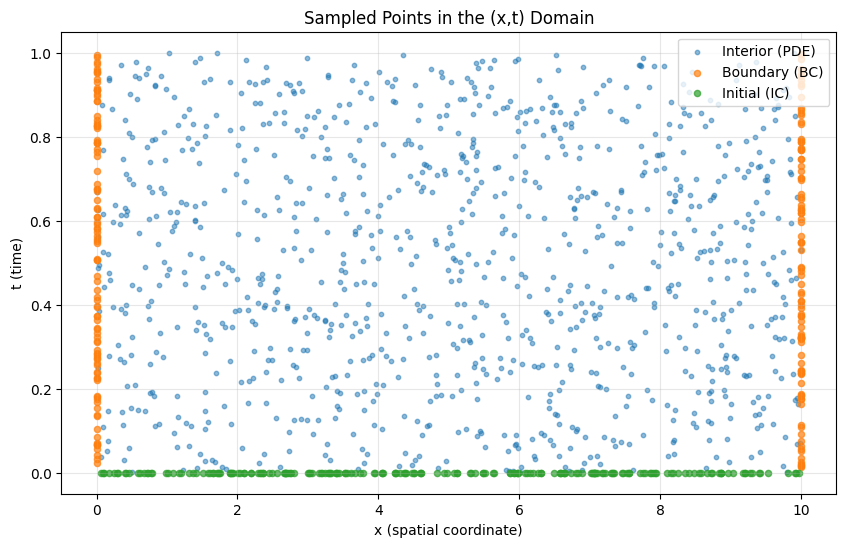

In [4]:
# Define domain parameters
L = 10.0          # Spatial domain length
t_start = 0.0     # Start time
t_end = 1.0       # End time

# Create geometry object
geo = Geometry(L=L, N=100, t_start=t_start, t_end=t_end, Nt=100)

# Sample points for visualization
key = random.PRNGKey(0)
N1 = 1000  # Interior points
N2 = 200   # Boundary points
N3 = 200   # Initial condition points

# Generate different types of points
key, subkey1, subkey2, subkey3 = random.split(key, 4)
points_interior = geo.sample_interior(subkey1, N1)
points_boundary = geo.sample_boundary(subkey2, N2)
points_initial = geo.sample_initial(subkey3, N3)

# Visualize the sampled points
plt.figure(figsize=(10, 6))
plt.scatter(points_interior[:, 0], points_interior[:, 1], 
            label='Interior (PDE)', alpha=0.5, s=10)
plt.scatter(points_boundary[:, 0], points_boundary[:, 1], 
            label='Boundary (BC)', alpha=0.7, s=20)
plt.scatter(points_initial[:, 0], points_initial[:, 1], 
            label='Initial (IC)', alpha=0.7, s=20)
plt.xlim(-0.5, L+0.5)
plt.ylim(-0.05, t_end+0.05)
plt.xlabel('x (spatial coordinate)')
plt.ylabel('t (time)')
plt.title('Sampled Points in the (x,t) Domain')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Neural Network Architecture

**Task 3.1:** Define a Neural Network that will approximate the solution `u(x, t)`

**Network Requirements:**

1. **Architecture constraints:**
   - Input layer: dimension = 2 (representing `x` and `t`)
   - Hidden layers: number and width are yours to choose (see tips below)
   - Output layer: dimension = 1 (representing `u(x, t)`)
   - Must satisfy the universal approximation theorem

2. **Activation function:**
   - Must be continuously differentiable (the network needs to compute derivatives)
   - Common choices: `tanh`, `sigmoid`, `softplus`, `GELU`
   - Avoid: `ReLU` (non-differentiable at 0, though often works in practice)

3. **Input/Output specification:**
   - Input: Array of shape `(N, 2)` containing `(x, t)` coordinates
   - Output: Array of shape `(N, 1)` containing predicted `u(x, t)` values

**💡 Tips:**

1. **Model capacity:** Start simple, then increase complexity if needed
   - For this 1D heat equation, try starting with 2-3 hidden layers of 20-50 neurons each
   - If the model doesn't learn well, consider increasing depth or width
   - If training is slow or unstable, try reducing complexity

2. **Parameter initialization:** This is critical for PINN training!
   - **Problem:** Random normal initialization often leads to trivial solutions (e.g., `u ≈ 0` everywhere)
   - **Solutions:**
     - Use **Glorot/Xavier uniform initialization** (strongly recommended)
     - Alternatively, use careful loss weighting (covered later)
   - Most deep learning libraries provide Glorot initialization (e.g., `glorot_uniform` in Keras/JAX)

3. **Implementation tips:**
   - Your network should be a callable function/class that takes `(x, t)` coordinates and returns `u` predictions
   - Ensure you can access intermediate gradients (needed for computing derivatives in the loss function)

In [5]:
from jax.nn.initializers import glorot_uniform

class Pinn:
    """
    Physics-Informed Neural Network for approximating the solution u(x, t).
    
    The network takes (x, t) coordinates as input and outputs u(x, t) predictions.
    Uses Glorot uniform initialization to avoid trivial solutions.
    """
    
    def __init__(self, key, layers):
        """
        Initialize the PINN.
        
        Parameters:
        -----------
        key : jax.random.PRNGKey
            Random key for parameter initialization
        layers : list of int
            Architecture specification, e.g., [2, 20, 20, 20, 1]
            - First element: input dimension (2 for x and t)
            - Middle elements: hidden layer widths
            - Last element: output dimension (1 for u)
        """
        self.layers = layers
        self.params = self.initialize_params(key, layers)

    def initialize_params(self, key, layers):
        """
        Initialize network parameters using Glorot uniform initialization.
        This helps avoid convergence to trivial solutions (u ≈ 0 everywhere).
        
        Returns:
        --------
        params : list of tuples
            Each tuple contains (weights, biases) for one layer
        """
        params = []
        keys = random.split(key, len(layers) - 1)
        
        for i, key_i in enumerate(keys):
            # Glorot uniform initialization for weights
            W = glorot_uniform()(key_i, (layers[i], layers[i + 1]))
            # Zero initialization for biases
            b = jnp.zeros((1, layers[i + 1]))
            params.append((W, b))
        
        return params

    def neural_net(self, params, x):
        """
        Forward pass through the network.
        
        Parameters:
        -----------
        params : list of tuples
            Network parameters (weights and biases)
        x : array of shape (N, 2)
            Input coordinates (x, t)
            
        Returns:
        --------
        output : array of shape (N, 1)
            Predicted values u(x, t)
        """
        # Forward pass through all hidden layers with tanh activation
        for W, b in params[:-1]:
            x = jnp.tanh(jnp.dot(x, W) + b)
        
        # Linear output layer (no activation)
        W, b = params[-1]
        x = jnp.dot(x, W) + b
        
        return x

    def __call__(self, x):
        """
        Make the network callable: pinn(x) instead of pinn.neural_net(pinn.params, x)
        """
        return self.neural_net(self.params, x)

## 4. Neural Network Validation

**Task 4.1:** Test your network implementation

Before moving to training, verify that:
1. Your network accepts inputs of shape `(N, 2)` and produces outputs of shape `(N, 1)`
2. You can generate sample points using your `Geometry` class and pass them through the network
3. The output values are reasonable (not `NaN` or extremely large)

**Suggestion:** Create a few test points using your `Geometry` class and check that forward propagation works correctly.

In [6]:
# Test the PINN implementation
layers = [2, 20, 20, 20, 1]  # Architecture: 2 inputs -> 3 hidden layers (20 neurons each) -> 1 output
key = random.PRNGKey(0)
pinn = Pinn(key, layers)

# Test forward pass with some example points
x_test = jnp.array([[1.0, 0.5],   # (x=1.0, t=0.5)
                     [2.0, 0.5]])   # (x=2.0, t=0.5)
u_test = pinn(x_test)

print("Test inputs (x, t):")
print(x_test)
print("\nTest outputs u(x, t):")
print(u_test)
print("\nNetwork initialized successfully! ✓")

Test inputs (x, t):
[[1.  0.5]
 [2.  0.5]]

Test outputs u(x, t):
[[0.10815172]
 [0.3297683 ]]

Network initialized successfully! ✓


## 5. Loss Functions

**Task 5.1:** Implement the physics-informed loss function

The loss function is what makes this network "physics-informed". It enforces the PDE, boundary conditions, and initial conditions. We split it into three components:

---

### 5.1 PDE Residual Loss: $\mathcal{L}_{PDE}$

This enforces that the network satisfies the heat equation at interior points.

**Mathematical definition:**

$$\mathcal{L}_{PDE}= \frac{1}{N_1} \sum_{i=1}^{N_1} \left(\frac{\partial}{\partial t}NN(x_i,t_i)-D\frac{\partial^2}{\partial x^2}NN(x_i,t_i)\right)^2$$

**Implementation requirements:**
- **Input:** 
  - Interior points `(x, t)` from `sample_interior(N1)` - shape `(N1, 2)`
  - Network prediction function `NN(x, t)`
  - Diffusion coefficient `D`
- **Steps:**
  1. For each point `(xi, ti)`, compute `u = NN(xi, ti)`
  2. Compute time derivative: `∂u/∂t` using automatic differentiation
  3. Compute second spatial derivative: `∂²u/∂x²` using automatic differentiation
  4. Calculate residual: `r = ∂u/∂t - D·∂²u/∂x²`
  5. Return mean squared residual: `mean(r²)`
- **Output:** Scalar value representing PDE residual loss

---

### 5.2 Boundary Condition Loss: $\mathcal{L}_{BC}$

This enforces Dirichlet boundary conditions: `u(0, t) = u(L, t) = 0` for all `t > 0`.

**Mathematical definition:**

$$\mathcal{L}_{BC}= \frac{1}{N_2} \sum_{i=1}^{N_2} (NN(x_i, t_i))^2 \quad \text{where } x_i \in \{0, L\}$$

**Implementation requirements:**
- **Input:**
  - Boundary points from `sample_boundary(N2)` - shape `(N2, 2)`, where `x ∈ {0, L}`
  - Network prediction function `NN(x, t)`
- **Steps:**
  1. Evaluate network at boundary points: `u_boundary = NN(x_boundary, t_boundary)`
  2. Return mean squared predictions: `mean(u_boundary²)`
- **Output:** Scalar value representing boundary condition loss
- **Note:** Since the boundary condition is `u = 0`, we simply penalize any non-zero predictions

---

### 5.3 Initial Condition Loss: $\mathcal{L}_{IC}$

This is the *supervised* component, enforcing the initial condition: `u(x, 0) = sin(πx/L)`.

**Mathematical definition:**

$$\mathcal{L}_{IC}=\frac{1}{N_3} \sum_{i=1}^{N_3} (NN(x_i,0)-\sin(\pi x_i/L))^2$$

**Implementation requirements:**
- **Input:**
  - Initial condition points from `sample_initial(N3)` - shape `(N3, 2)`, where `t = 0`
  - Network prediction function `NN(x, t)`
  - Domain length `L`
- **Steps:**
  1. Evaluate network at initial points: `u_pred = NN(x_initial, 0)`
  2. Compute exact initial condition: `u_exact = sin(π·x_initial/L)`
  3. Return mean squared error: `mean((u_pred - u_exact)²)`
- **Output:** Scalar value representing initial condition loss

---

### 5.4 Total Loss

$$\mathcal{L}_{total} = \mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{IC}$$

Optionally, you can use weighted losses: $\mathcal{L}_{total} = w_1\mathcal{L}_{PDE} + w_2\mathcal{L}_{BC} + w_3\mathcal{L}_{IC}$

---

**💡 Implementation Tips:**

1. **Automatic differentiation:** Use your framework's built-in tools
   - TensorFlow: `tf.GradientTape` (set `persistent=True` to compute multiple derivatives)
   - PyTorch: `torch.autograd.grad`
   - JAX: `jax.grad` or `jax.jacfwd`/`jax.jacrev`

2. **Computing higher-order derivatives:**
   - For `∂²u/∂x²`, you need to differentiate twice with respect to `x`
   - Ensure your automatic differentiation context can handle multiple derivative operations

3. **Debugging:** Test each loss component separately with known simple functions before combining them

In [7]:
import optax

def loss_pde(params, pinn, points, D):
    """
    Compute the PDE residual loss: L_PDE.
    
    Enforces the heat equation: ∂u/∂t = D * ∂²u/∂x²
    
    Parameters:
    -----------
    params : list
        Network parameters
    pinn : Pinn
        PINN object
    points : array of shape (N1, 2)
        Interior points (x, t)
    D : float
        Diffusion coefficient
        
    Returns:
    --------
    loss : float
        Mean squared PDE residual
    """
    def pde_residual(point):
        """Compute PDE residual at a single point."""
        x, t = point[0], point[1]
        
        # Define function u(x, t) for automatic differentiation
        def u_fn(x_val, t_val):
            input_point = jnp.array([[x_val, t_val]])
            return pinn.neural_net(params, input_point)[0, 0]
        
        # Compute derivatives using JAX automatic differentiation
        # First derivative: ∂u/∂t
        u_t = grad(u_fn, argnums=1)(x, t)
        
        # Second derivative: ∂²u/∂x²
        # (apply grad twice with respect to x)
        u_xx = grad(grad(u_fn, argnums=0), argnums=0)(x, t)
        
        # PDE residual: ∂u/∂t - D * ∂²u/∂x²
        residual = u_t - D * u_xx
        
        return residual**2
    
    # Vectorize the residual computation over all points
    residuals = vmap(pde_residual)(points)
    
    return jnp.mean(residuals)


def loss_bc(params, pinn, points):
    """
    Compute the boundary condition loss: L_BC.
    
    Enforces Dirichlet BC: u(0, t) = u(L, t) = 0
    
    Parameters:
    -----------
    params : list
        Network parameters
    pinn : Pinn
        PINN object
    points : array of shape (N2, 2)
        Boundary points where x ∈ {0, L}
        
    Returns:
    --------
    loss : float
        Mean squared boundary predictions (should be zero)
    """
    # Evaluate network at boundary points
    predictions = pinn.neural_net(params, points)
    
    # Since BC is u=0, we penalize any non-zero predictions
    return jnp.mean(predictions**2)


def loss_ic(params, pinn, points, L):
    """
    Compute the initial condition loss: L_IC.
    
    Enforces IC: u(x, 0) = sin(πx/L)
    
    Parameters:
    -----------
    params : list
        Network parameters
    pinn : Pinn
        PINN object
    points : array of shape (N3, 2)
        Initial condition points where t = 0
    L : float
        Domain length
        
    Returns:
    --------
    loss : float
        Mean squared error between predictions and exact IC
    """
    # Network predictions at t=0
    predictions = pinn.neural_net(params, points)
    
    # Exact initial condition: u(x, 0) = sin(πx/L)
    u_exact = jnp.sin(jnp.pi * points[:, 0:1] / L)
    
    # Mean squared error
    return jnp.mean((predictions - u_exact)**2)


def total_loss(params, pinn, points_interior, points_boundary, points_initial, D, L):
    """
    Compute the total physics-informed loss.
    
    L_total = L_PDE + L_BC + L_IC
    
    Parameters:
    -----------
    params : list
        Network parameters
    pinn : Pinn
        PINN object
    points_interior : array
        Interior domain points
    points_boundary : array
        Boundary points
    points_initial : array
        Initial condition points
    D : float
        Diffusion coefficient
    L : float
        Domain length
        
    Returns:
    --------
    total : float
        Total loss value
    components : tuple
        Individual loss components (l_pde, l_bc, l_ic) for monitoring
    """
    l_pde = loss_pde(params, pinn, points_interior, D)
    l_bc = loss_bc(params, pinn, points_boundary)
    l_ic = loss_ic(params, pinn, points_initial, L)
    
    total = l_pde + l_bc + l_ic
    
    return total, (l_pde, l_bc, l_ic)

## 6. Loss Function Validation

**Task 6.1:** Test your loss implementations

Before training, verify that each loss component works correctly:

1. **Test with simple inputs:**
   - Sample a small number of points (e.g., `N1=10`, `N2=10`, `N3=10`)
   - Compute each loss term separately
   - Check that all values are finite (not `NaN` or `Inf`)

2. **Sanity checks:**
   - For a randomly initialized network, all losses should be non-zero
   - `L_BC` should be relatively small if the network happens to predict values close to zero at boundaries
   - `L_IC` depends on how far the random predictions are from `sin(πx/L)`

3. **Test derivatives:**
   - Ensure automatic differentiation is computing gradients correctly
   - Try evaluating `∂u/∂t` and `∂²u/∂x²` at a single point and verify they are computable

**Debugging tip:** If you encounter errors, test each loss function independently before combining them.

In [8]:
# Test the loss functions with random samples
key = random.PRNGKey(0)

# Sample test points
N1_test = 100  # Small number for testing
N2_test = 20
N3_test = 20

key, subkey1, subkey2, subkey3 = random.split(key, 4)
points_interior = geo.sample_interior(subkey1, N1_test)
points_boundary = geo.sample_boundary(subkey2, N2_test)
points_initial = geo.sample_initial(subkey3, N3_test)

# Compute each loss component
D_test = 3
l_pde = loss_pde(pinn.params, pinn, points_interior, D_test)
l_bc = loss_bc(pinn.params, pinn, points_boundary)
l_ic = loss_ic(pinn.params, pinn, points_initial, geo.L)

print("Loss components for untrained network:")
print(f"  L_PDE (PDE residual):        {l_pde:.6f}")
print(f"  L_BC  (Boundary conditions): {l_bc:.6f}")
print(f"  L_IC  (Initial condition):   {l_ic:.6f}")
print(f"  L_total:                     {l_pde + l_bc + l_ic:.6f}")
print("\nAll losses computed successfully! ✓")

Loss components for untrained network:
  L_PDE (PDE residual):        0.027606
  L_BC  (Boundary conditions): 0.248489
  L_IC  (Initial condition):   0.096955
  L_total:                     0.373050

All losses computed successfully! ✓


## 7. Training Loop

**Task 7.1:** Implement the training procedure

Now that all components are ready, implement the optimization loop to train your PINN.

---

### 7.1 Core Training Operations

Your training loop should perform these steps at each iteration:

1. **Sample points:** Generate new random sets of:
   - Interior points `(x, t)` using `sample_interior(N1)`
   - Boundary points `(x, t)` using `sample_boundary(N2)`
   - Initial condition points `(x, 0)` using `sample_initial(N3)`

2. **Forward pass & loss computation:**
   - Evaluate the network at all sampled points
   - Compute `L_PDE`, `L_BC`, `L_IC`, and `L_total`

3. **Backward pass & optimization:**
   - Compute gradients of `L_total` with respect to network parameters
   - Update parameters using an optimizer (Adam recommended)

4. **Monitoring:**
   - Print/log loss values periodically
   - Track the best model (lowest total loss)
   - Save checkpoints when a new minimum is reached

---

### 7.2 Implementation Suggestions

For clean, readable code, consider organizing as follows:

**Option A: Unified PDE function**
- Create a function `compute_pde_loss(model, interior_points, boundary_points, initial_points, D, L)` that:
  - Takes all inputs and hyperparameters
  - Returns all loss components `(L_total, L_PDE, L_BC, L_IC)`
- Your training loop then only needs:
  1. Sample points from `Geometry` class
  2. Call `compute_pde_loss()` within gradient computation context
  3. Apply optimizer step
  4. Monitor and save

**Option B: Separate components**
- Keep loss functions separate as implemented in Task 5
- Call them individually in the training loop

---

### 7.3 Training Hyperparameters

**Optimizer:**
- **Recommended:** Adam with learning rate `1e-3` to `1e-4`
- **Alternative:** Try L-BFGS for fine-tuning after initial Adam training (see tips below)

**Number of epochs:**
- Start with 5,000-10,000 epochs
- Monitor loss curves to determine if more training is needed

**Sampling sizes:**
- Typical values: `N1=1000`, `N2=200`, `N3=200`
- Adjust based on computational resources and convergence behavior

---

### 7.4 Tips & Best Practices

**1. Loss weighting (if needed):**
   - If one loss component dominates, consider weighting: `L_total = w1·L_PDE + w2·L_BC + w3·L_IC`
   - Start with equal weights (1, 1, 1) and adjust if necessary

**2. Advanced optimization - L-BFGS:**
   - Some PINN literature recommends [L-BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) (second-order optimizer)
   - **Strategy:** Train with Adam first, then fine-tune with L-BFGS
   - Not required but can improve convergence

**3. Monitoring:**
   - Print each loss component separately to diagnose issues
   - If one component doesn't decrease, check its implementation

**4. Stopping criterion:**
   - **Key question:** *Without a validation set, how do you decide when to stop training?*
   - Consider:
     - Has the total loss plateaued?
     - Are all three loss components sufficiently small?
     - Does the solution look physically reasonable?
     - Compare with analytical solution (if available, as in this exercise)

**5. Checkpointing:**
   - Save the model parameters whenever `L_total` reaches a new minimum
   - This protects against divergence in later epochs

---

### 7.5 Expected Behavior

During training, you should observe:
- All loss components decreasing over time
- `L_IC` typically decreases fastest (it's supervised)
- `L_PDE` often decreases more slowly
- Total loss should eventually plateau at a low value (e.g., < 0.01 or lower)

In [9]:
def train_pinn(pinn, geo, D, L, n_epochs=5000, N1=1000, N2=200, N3=200, learning_rate=1e-3):
    """
    Train the Physics-Informed Neural Network.
    
    Parameters:
    -----------
    pinn : Pinn
        PINN object to train
    geo : Geometry
        Geometry object for sampling points
    D : float
        Diffusion coefficient
    L : float
        Domain length
    n_epochs : int
        Number of training iterations
    N1, N2, N3 : int
        Number of interior, boundary, and initial condition points per epoch
    learning_rate : float
        Adam optimizer learning rate
        
    Returns:
    --------
    loss_history : list
        Total loss at each epoch
    loss_components : dict
        History of individual loss components
    """
    # Initialize Adam optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(pinn.params)
    
    # For tracking best model
    best_loss = float('inf')
    best_params = pinn.params
    
    # Loss history for monitoring
    loss_history = []
    loss_components = {'pde': [], 'bc': [], 'ic': []}
    
    # Random key
    key = random.PRNGKey(0)
    
    print(f"Starting training for {n_epochs} epochs...")
    print(f"Sampling: N1={N1} (interior), N2={N2} (boundary), N3={N3} (initial)\n")
    
    for epoch in range(n_epochs):
        # Generate new random points for this epoch
        key, subkey1, subkey2, subkey3 = random.split(key, 4)
        
        points_interior = geo.sample_interior(subkey1, N1)
        points_boundary = geo.sample_boundary(subkey2, N2)
        points_initial = geo.sample_initial(subkey3, N3)
        
        # Compute loss and gradients
        (loss_val, (l_pde, l_bc, l_ic)), grads = jax.value_and_grad(total_loss, has_aux=True)(
            pinn.params, pinn, points_interior, points_boundary, points_initial, D, L
        )
        
        # Update parameters using Adam
        updates, opt_state = optimizer.update(grads, opt_state)
        pinn.params = optax.apply_updates(pinn.params, updates)
        
        # Track best model
        if loss_val < best_loss:
            best_loss = loss_val
            best_params = pinn.params
        
        # Store history
        loss_history.append(loss_val)
        loss_components['pde'].append(l_pde)
        loss_components['bc'].append(l_bc)
        loss_components['ic'].append(l_ic)
        
        # Print progress
        if epoch % 500 == 0:
            print(f"Epoch {epoch:5d}: L_total = {loss_val:.6f} | "
                  f"L_PDE = {l_pde:.6f} | L_BC = {l_bc:.6f} | L_IC = {l_ic:.6f}")
    
    # Restore best parameters
    print(f"\nTraining complete! Best loss: {best_loss:.6f}")
    pinn.params = best_params
    
    return loss_history, loss_components




In [10]:
# run all tests
all_passed = run_all_tests(Geometry=Geometry, Pinn=Pinn, loss_pde=loss_pde, loss_bc=loss_bc, loss_ic=loss_ic, total_loss=total_loss, train_pinn=train_pinn, verbose=True)
if all_passed:
    print("\n🎉 All tests passed! The solution is correctly implemented.")


RUNNING COMPREHENSIVE TEST SUITE

Testing Geometry Class


TEST SUMMARY

✅ PASSED (5 tests):
   • Geometry initialization
   • Geometry.sample_interior()
   • Geometry.sample_boundary()
   • Geometry.sample_initial()
   • Geometry.sample_at_time() [OPTIONAL]

Total: 5/5 tests passed

Testing PINN Class


TEST SUMMARY

✅ PASSED (5 tests):
   • Geometry initialization
   • Geometry.sample_interior()
   • Geometry.sample_boundary()
   • Geometry.sample_initial()
   • Geometry.sample_at_time() [OPTIONAL]

Total: 5/5 tests passed

Testing PINN Class


TEST SUMMARY

✅ PASSED (4 tests):
   • PINN initialization
   • PINN forward pass
   • PINN output variation
   • PINN parameter initialization (Glorot-like)

Total: 4/4 tests passed

Testing Loss Functions


TEST SUMMARY

✅ PASSED (4 tests):
   • PINN initialization
   • PINN forward pass
   • PINN output variation
   • PINN parameter initialization (Glorot-like)

Total: 4/4 tests passed

Testing Loss Functions


TEST SUMMARY

✅ PASSED (5 te

TRAINING PHYSICS-INFORMED NEURAL NETWORK
Starting training for 1000 epochs...
Sampling: N1=1000 (interior), N2=200 (boundary), N3=200 (initial)

Epoch     0: L_total = 1.647954 | L_PDE = 0.191062 | L_BC = 1.000719 | L_IC = 0.456173
Epoch     0: L_total = 1.647954 | L_PDE = 0.191062 | L_BC = 1.000719 | L_IC = 0.456173
Epoch   500: L_total = 0.002863 | L_PDE = 0.001686 | L_BC = 0.000337 | L_IC = 0.000840
Epoch   500: L_total = 0.002863 | L_PDE = 0.001686 | L_BC = 0.000337 | L_IC = 0.000840

Training complete! Best loss: 0.000301

Training complete! Best loss: 0.000301


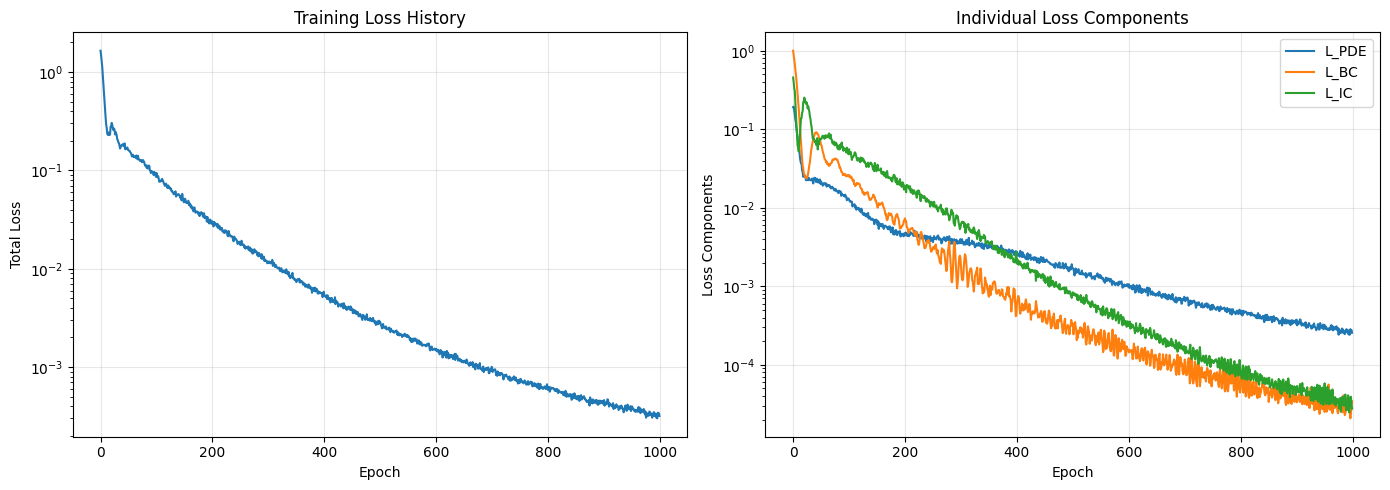

In [11]:
# Train the PINN
print("="*70)
print("TRAINING PHYSICS-INFORMED NEURAL NETWORK")
print("="*70)

# Define problem parameters
L = 10.0
D = 3

# Create a fresh PINN
layers = [2, 20, 20, 20, 1]
key = random.PRNGKey(42)
pinn = Pinn(key, layers)

# Train
loss_history, loss_components = train_pinn(
    pinn, geo, D, L, 
    n_epochs=1000, 
    N1=1000, N2=200, N3=200,
    learning_rate=1e-3
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total loss
axes[0].plot(loss_history, linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Training Loss History')
axes[0].grid(True, alpha=0.3)

# Individual components
axes[1].plot(loss_components['pde'], label='L_PDE', linewidth=1.5)
axes[1].plot(loss_components['bc'], label='L_BC', linewidth=1.5)
axes[1].plot(loss_components['ic'], label='L_IC', linewidth=1.5)
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Components')
axes[1].set_title('Individual Loss Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Performance Evaluation

**Task 8.1:** Evaluate and analyze your trained PINN

Now that your model is trained, assess its performance and understand its behavior.

---

### 8.1 Quantitative Metrics

**Primary metric - Mean Absolute Error (MAE):**

Since we have the analytical solution for this problem:

$$u_{exact}(x,t) = \sin\!\left(\frac{\pi x}{L}\right) \exp\!\left(-\frac{\pi^2 D}{L^2} t\right)$$

Compute:
- **Absolute Error:** `|u_pred(x,t) - u_exact(x,t)|`
- **Mean Absolute Error:** Average absolute error over the domain
- **Maximum Error:** Worst-case pointwise error
- **Relative Error:** `|u_pred - u_exact| / |u_exact|` (where `u_exact ≠ 0`)

**Questions to answer:**
1. What is the average error across the entire domain?
2. Where is the error largest? (boundaries? interior? early/late times?)
3. Is the error acceptable for your application?

---

### 8.2 Qualitative Assessment

**Visualization tasks:**

1. **Solution comparison:**
   - Plot `u_pred(x,t)` as a heatmap/contour plot
   - Plot `u_exact(x,t)` as a heatmap/contour plot
   - Visually compare: Does the PINN capture the correct behavior?

2. **Error visualization:**
   - Plot absolute error `|u_pred - u_exact|` as a heatmap
   - Identify regions of high/low error

3. **Time slices:**
   - Plot `u(x, t)` vs `x` at several fixed times (e.g., `t = 0, 0.25, 0.5, 0.75, 1.0`)
   - Compare PINN predictions with analytical solution
   - Does the solution decay correctly over time?

4. **Spatial profiles:**
   - Plot `u(x, t)` vs `t` at several fixed locations (e.g., `x = L/4, L/2, 3L/4`)
   - Verify exponential decay in time

---

### 8.3 Comparison with Classical Methods

**Task 8.2:** Compare PINN with numerical methods

To understand PINNs' strengths and limitations, compare with traditional PDE solvers:

**Suggested method - FTCS (Forward-Time Central-Space):**
- Simple explicit finite difference scheme for the heat equation
- Discretize in space and time: `u[n+1, i] = u[n, i] + D·dt/dx²·(u[n,i+1] - 2u[n,i] + u[n,i-1])`
- **Note:** Check stability condition: `D·dt/dx² ≤ 0.5`

**Comparison criteria:**

1. **Accuracy:**
   - Which method has lower error compared to the analytical solution?
   - How does error scale with grid resolution (for FTCS) vs network size (for PINN)?

2. **Computational cost:**
   - Training time for PINN vs solve time for FTCS
   - Memory requirements

3. **Flexibility:**
   - How easy is it to change domain size, boundary conditions, or initial conditions?
   - Which method generalizes better to new scenarios?

4. **Physical constraints:**
   - Does the PINN naturally satisfy physical properties (e.g., positivity, conservation)?
   - Compare with FTCS in this regard

---

### 8.4 Reflection Questions

1. **When would you prefer a PINN over classical methods?**
   - Consider: sparse data, inverse problems, complex geometries, parameter estimation

2. **What are the main challenges you encountered?**
   - Hyperparameter tuning? Training stability? Computational cost?

3. **How would this approach scale to higher dimensions (2D/3D)?**
   - Think about: computational complexity, sampling strategies, network architecture

4. **What happens if you reduce the number of training points?**
   - Try reducing `N1`, `N2`, or `N3` and observe the effect on accuracy


QUANTITATIVE PERFORMANCE METRICS
Mean Absolute Error (MAE):     2.666327e-03
Maximum Absolute Error:        1.210630e-02
Mean Relative Error:           5.683291e+05



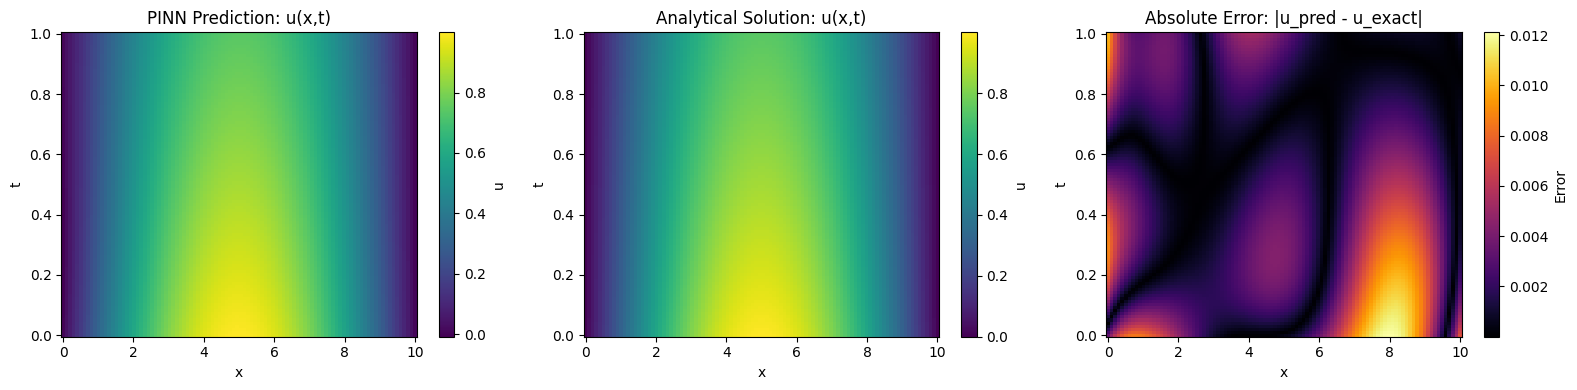

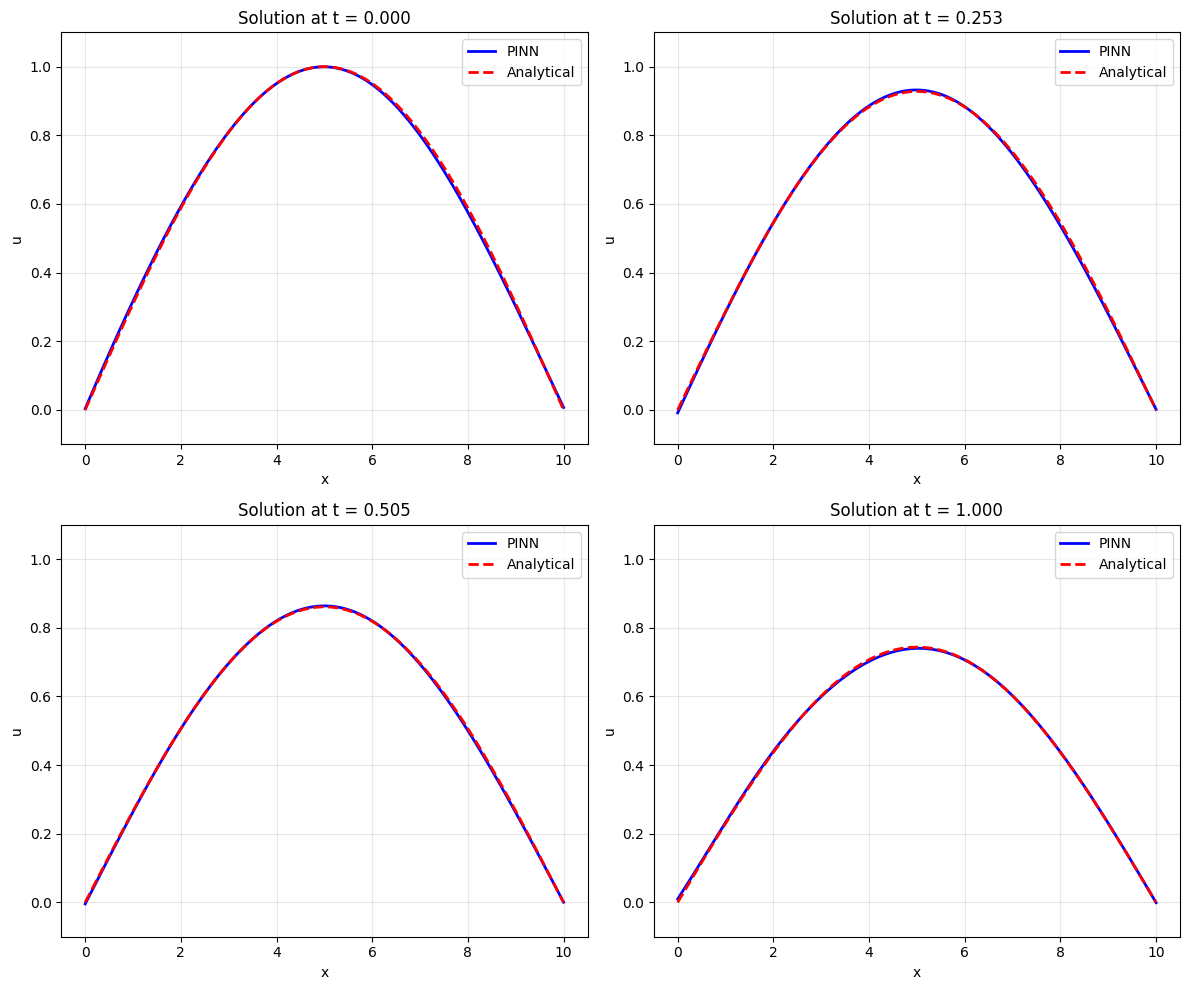

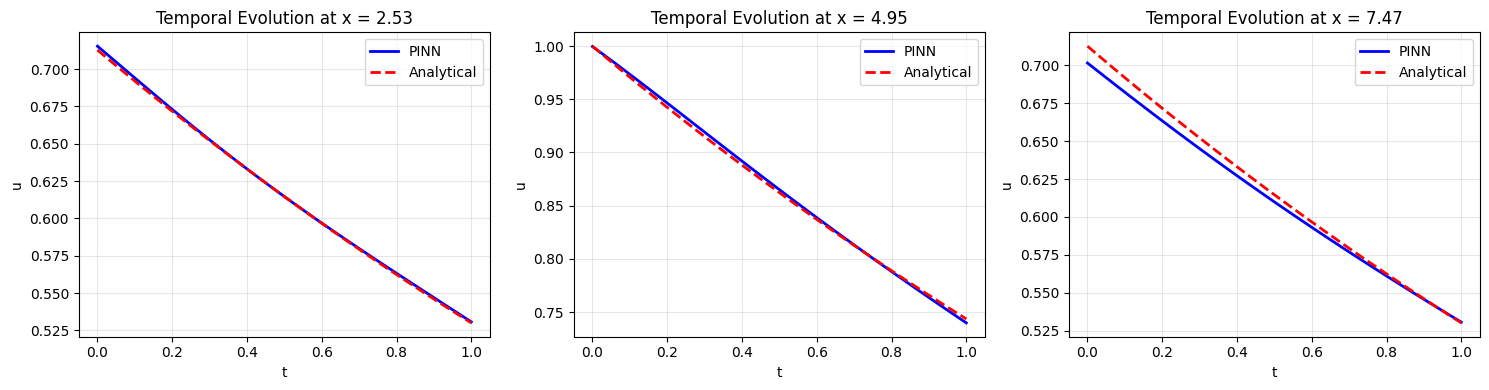

In [12]:
# ============================================================================
# PERFORMANCE EVALUATION: Compare PINN predictions with analytical solution
# ============================================================================

# Create a grid for evaluation
x = geo.x
t = geo.t
X, T = jnp.meshgrid(x, t)

# Flatten for network evaluation
XT = jnp.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# PINN predictions
u_pred = pinn(XT).reshape(X.shape)

# Analytical solution: u(x,t) = sin(πx/L) * exp(-π²Dt/L²)
u_exact = jnp.sin(jnp.pi * X / L) * jnp.exp(-D * (jnp.pi / L)**2 * T)

# ============================================================================
# 8.1 Quantitative Metrics
# ============================================================================

mae = jnp.mean(jnp.abs(u_pred - u_exact))
max_error = jnp.max(jnp.abs(u_pred - u_exact))
rel_error = jnp.mean(jnp.abs(u_pred - u_exact) / (jnp.abs(u_exact) + 1e-10))

print("\n" + "="*70)
print("QUANTITATIVE PERFORMANCE METRICS")
print("="*70)
print(f"Mean Absolute Error (MAE):     {mae:.6e}")
print(f"Maximum Absolute Error:        {max_error:.6e}")
print(f"Mean Relative Error:           {rel_error:.6e}")
print("="*70 + "\n")

# ============================================================================
# 8.2 Qualitative Assessment: Visualizations
# ============================================================================

# 1. Solution comparison (heatmaps)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# PINN prediction
im1 = axes[0].pcolormesh(X, T, u_pred, shading='auto', cmap='viridis')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('PINN Prediction: u(x,t)')
plt.colorbar(im1, ax=axes[0], label='u')

# Analytical solution
im2 = axes[1].pcolormesh(X, T, u_exact, shading='auto', cmap='viridis')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('Analytical Solution: u(x,t)')
plt.colorbar(im2, ax=axes[1], label='u')

# Absolute error
residual = jnp.abs(u_pred - u_exact)
im3 = axes[2].pcolormesh(X, T, residual, shading='auto', cmap='inferno')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Absolute Error: |u_pred - u_exact|')
plt.colorbar(im3, ax=axes[2], label='Error')

plt.tight_layout()
plt.show()

# ============================================================================
# 2. Time slices: u(x, t) at fixed times
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
times = [0.0, 0.25, 0.5, 1.0]

for idx, t_slice in enumerate(times):
    ax = axes[idx // 2, idx % 2]
    
    # Find closest time index
    t_idx = jnp.argmin(jnp.abs(t - t_slice))
    
    # Extract predictions and exact solution at this time
    u_pred_slice = u_pred[t_idx, :]
    u_exact_slice = u_exact[t_idx, :]
    
    # Plot
    ax.plot(x, u_pred_slice, label='PINN', color='blue', linewidth=2)
    ax.plot(x, u_exact_slice, label='Analytical', color='red', 
            linestyle='--', linewidth=2)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    # set y-axis limits from -0.1 to 1.1
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(f'Solution at t = {t[t_idx]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. Spatial profiles: u(x, t) at fixed locations
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
x_locations = [L/4, L/2, 3*L/4]

for idx, x_loc in enumerate(x_locations):
    # Find closest x index
    x_idx = jnp.argmin(jnp.abs(x - x_loc))
    
    # Extract predictions and exact solution at this location
    u_pred_profile = u_pred[:, x_idx]
    u_exact_profile = u_exact[:, x_idx]
    
    # Plot temporal evolution at this location
    axes[idx].plot(t, u_pred_profile, label='PINN', color='blue', linewidth=2)
    axes[idx].plot(t, u_exact_profile, label='Analytical', color='red', 
                   linestyle='--', linewidth=2)
    axes[idx].set_xlabel('t')
    axes[idx].set_ylabel('u')
    axes[idx].set_title(f'Temporal Evolution at x = {x[x_idx]:.2f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# 🚀 ADVANCED / OPTIONAL EXERCISES

The following sections are **optional** and explore more advanced topics:
- **Section 8.3**: Comparison with classical numerical methods (FTCS)
- **Section 9**: Inverse problem - reconstructing initial conditions from measurements

These are excellent extensions if you want to deepen your understanding, but are **not required** for completing the core exercise.

---


Solving with FTCS method...
FTCS stability parameter (should be ≤ 0.5): 1.4775


/home/fvaselli/miniconda3/envs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_constructors.py:246: RuntimeWarning: overflow encountered in cast
  out = np.asarray(object, dtype=dtype)



FTCS Method Errors:
  Mean Absolute Error: inf
  Maximum Error:       inf

Comparison:
  PINN MAE:  2.666327e-03
  FTCS MAE:  inf
  Winner:    PINN (lower MAE)


/home/fvaselli/miniconda3/envs/jax/lib/python3.12/site-packages/jax/_src/abstract_arrays.py:111: RuntimeWarning: overflow encountered in cast
  return literals.LiteralArray(np.asarray(x, dtype), weak_type=False)


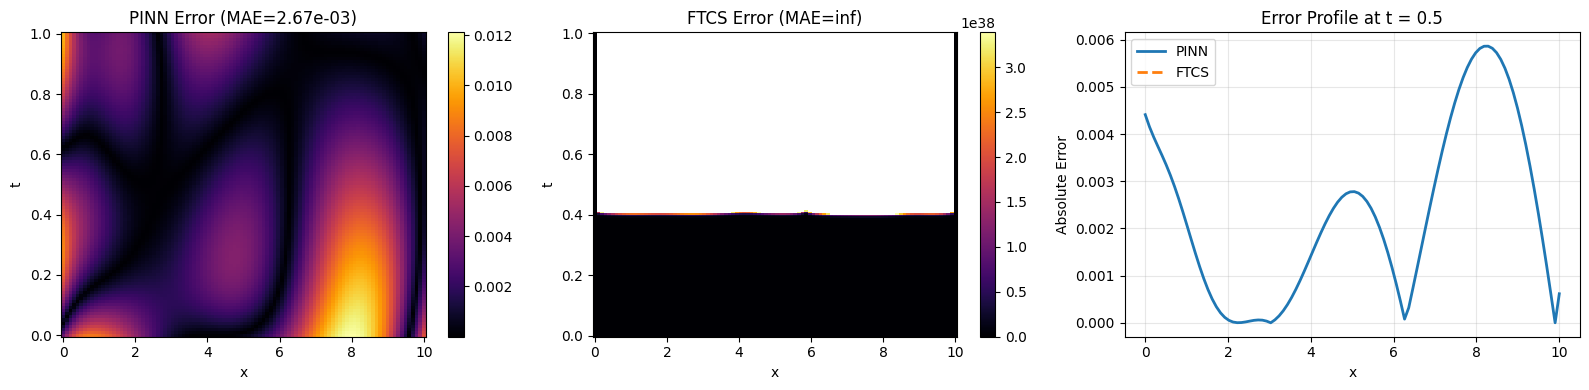

In [13]:
# ============================================================================
# 8.3 OPTIONAL: Comparison with Classical Method: FTCS (Forward-Time Central-Space)
# ============================================================================

def solve_heat_ftcs(L, T, D, nx, nt, ic_func):
    """
    Solve the 1D heat equation using the FTCS explicit finite difference method.
    
    Parameters:
    -----------
    L : float
        Domain length
    T : float
        Final time
    D : float
        Diffusion coefficient
    nx : int
        Number of spatial grid points
    nt : int
        Number of time steps
    ic_func : function
        Initial condition function u(x, 0)
        
    Returns:
    --------
    x : array
        Spatial grid
    t : array
        Time grid
    u : array
        Solution u(x, t)
    """
    # Grid setup
    dx = L / (nx - 1)
    dt = T / (nt - 1)
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    
    # Check stability condition: D*dt/dx² ≤ 0.5
    stability_param = D * dt / dx**2
    print(f"FTCS stability parameter (should be ≤ 0.5): {stability_param:.4f}")
    
    if stability_param > 0.5:
        print("WARNING: FTCS scheme may be unstable!")
    
    # Initialize solution
    u = np.zeros((nt, nx))
    u[0, :] = ic_func(x)
    
    # Time integration
    for n in range(0, nt-1):
        for i in range(1, nx-1):
            # FTCS formula: u[n+1,i] = u[n,i] + D*dt/dx² * (u[n,i+1] - 2*u[n,i] + u[n,i-1])
            u[n+1, i] = u[n, i] + stability_param * (u[n, i+1] - 2*u[n, i] + u[n, i-1])
        
        # Boundary conditions: u(0,t) = u(L,t) = 0
        u[n+1, 0] = 0
        u[n+1, -1] = 0
    
    return x, t, u


# Initial condition function
def ic_sin(x):
    return np.sin(np.pi * x / L)

# Solve using FTCS
print("\nSolving with FTCS method...")
x_ftcs, t_ftcs, u_ftcs = solve_heat_ftcs(L, t_end, D, nx=100, nt=200, ic_func=ic_sin)

# Convert to JAX arrays for comparison
u_ftcs_jax = jnp.array(u_ftcs)
X_ftcs, T_ftcs = jnp.meshgrid(x_ftcs, t_ftcs)

# Compute analytical solution on FTCS grid
u_exact_ftcs = jnp.sin(jnp.pi * X_ftcs / L) * jnp.exp(-D * (jnp.pi / L)**2 * T_ftcs)

# Compute errors
ftcs_mae = jnp.mean(jnp.abs(u_ftcs_jax - u_exact_ftcs))
ftcs_max_error = jnp.max(jnp.abs(u_ftcs_jax - u_exact_ftcs))

print(f"\nFTCS Method Errors:")
print(f"  Mean Absolute Error: {ftcs_mae:.6e}")
print(f"  Maximum Error:       {ftcs_max_error:.6e}")

print(f"\nComparison:")
print(f"  PINN MAE:  {mae:.6e}")
print(f"  FTCS MAE:  {ftcs_mae:.6e}")
print(f"  Winner:    {'PINN' if mae < ftcs_mae else 'FTCS'} (lower MAE)")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# PINN error
im1 = axes[0].pcolormesh(X, T, jnp.abs(u_pred - u_exact), shading='auto', cmap='inferno')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title(f'PINN Error (MAE={mae:.2e})')
plt.colorbar(im1, ax=axes[0])

# FTCS error
im2 = axes[1].pcolormesh(X_ftcs, T_ftcs, jnp.abs(u_ftcs_jax - u_exact_ftcs), 
                         shading='auto', cmap='inferno')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title(f'FTCS Error (MAE={ftcs_mae:.2e})')
plt.colorbar(im2, ax=axes[1])

# Error comparison at t=0.5
t_compare = 0.5
t_idx_pinn = jnp.argmin(jnp.abs(t - t_compare))
t_idx_ftcs = np.argmin(np.abs(t_ftcs - t_compare))

axes[2].plot(x, jnp.abs(u_pred[t_idx_pinn, :] - u_exact[t_idx_pinn, :]), 
             label='PINN', linewidth=2)
axes[2].plot(x_ftcs, np.abs(u_ftcs[t_idx_ftcs, :] - u_exact_ftcs[t_idx_ftcs, :]), 
             label='FTCS', linewidth=2, linestyle='--')
axes[2].set_xlabel('x')
axes[2].set_ylabel('Absolute Error')
axes[2].set_title(f'Error Profile at t = {t_compare}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 🔬 ADVANCED: Inverse Problem Challenge

**Task 9.1:** Recover the initial distribution from a later measurement (inverse problem)

This advanced exercise explores one of PINNs' most powerful capabilities: solving inverse problems.

---

### 9.1 Problem Setup

You will be provided with experimental data (*to be added soon*):
- **Initial distribution:** `u(x, 0)` at time `t = 0`
- **Diffused distribution:** `u(x, t_measurement)` at a later time `t = t_measurement`

**Your goal:** Starting from the measurement at `t = t_measurement`, reconstruct the initial distribution at `t = 0`.

This is an **inverse problem** (going backward in time) and is generally ill-posed for the heat equation due to its irreversible nature.

---

### 9.2 Implementation Strategy

**Modifications to your PINN:**

1. **Change the supervised data:**
   - Instead of using the initial condition `u(x, 0) = sin(πx/L)` as training data...
   - Use the measurement at `t = t_measurement` as your supervised constraint
   - New loss: `L_data = mean((NN(x, t_measurement) - u_measured(x, t_measurement))²)`

2. **Predict backward:**
   - Train the network to satisfy the PDE throughout `t ∈ [0, t_measurement]`
   - The network should learn to "reverse" the diffusion process
   - After training, evaluate `NN(x, 0)` to get the reconstructed initial condition

3. **Handle discrete measurements:**
   - **Challenge:** You only have discrete measurement points, not a continuous function
   - **Solution:** Use interpolation to evaluate `u_measured` at arbitrary points
   - Suggested: [Scipy interpolation](https://docs.scipy.org/doc/scipy/reference/interpolate.html) (e.g., `scipy.interpolate.interp1d` or `scipy.interpolate.CubicSpline`)

---

### 9.3 Modified Loss Function

Your new total loss should be:

$$\mathcal{L}_{total} = \mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{data}$$

Where:
- `L_PDE`: Same as before (enforces heat equation throughout the domain)
- `L_BC`: Same as before (enforces boundary conditions)
- `L_data`: New supervised loss using measurements at `t = t_measurement`

Note: You're replacing `L_IC` (initial condition supervision) with `L_data` (measurement supervision).

---

### 9.4 Key Questions to Explore

**Question 9.1:** *How far back in time can you reliably reconstruct?*

Experiment with different values of `t_measurement`:
- Start with small values (e.g., `t_measurement = 0.1`)
- Gradually increase (e.g., 0.5, 1.0, 2.0, ...)
- At what point does reconstruction fail or become very inaccurate?

**Factors to investigate:**
1. **Reconstruction error vs. time:**
   - Plot reconstruction error as a function of `t_measurement`
   - Observe when error grows unacceptably large

2. **Role of noise:**
   - Add Gaussian noise to the measurement data: `u_noisy = u_measured + ε·N(0,1)`
   - How does noise affect reconstruction quality?
   - Try different noise levels

3. **Regularization:**
   - Can you improve reconstruction by adding regularization terms to the loss?
   - Example: Penalize roughness of the initial condition

4. **Physical intuition:**
   - Why does the heat equation make backward reconstruction difficult?
   - Think about information loss during diffusion
   - How does this relate to the second law of thermodynamics?

---

### 9.5 Expected Challenges

1. **Training instability:**
   - Inverse problems are typically more difficult to train
   - You may need: smaller learning rates, more iterations, better initialization

2. **Non-uniqueness:**
   - Multiple initial conditions might produce similar measurements
   - The PINN might converge to different solutions with different random seeds

3. **Sensitivity to hyperparameters:**
   - Loss weighting becomes more critical
   - Network architecture may need adjustment

**Tips:**
- Start with small `t_measurement` where the problem is easier
- Use multiple random seeds and compare results
- Visualize intermediate solutions during training to debug issues

---

### 9.6 Extension Ideas

If you complete the basic inverse problem, consider:
1. **Unknown diffusion coefficient:** Simultaneously learn `D` and initial condition
2. **Sparse measurements:** Use only a few spatial points at `t_measurement`
3. **Multiple time measurements:** Use data at several different times
4. **2D heat equation:** Extend to two spatial dimensions

INVERSE PROBLEM: RECONSTRUCTING INITIAL CONDITION

Generating synthetic measurement at t = 0.3...
  Measurement points: 50
  Noise level: 0.01
  Measurement points: 50
  Noise level: 0.01


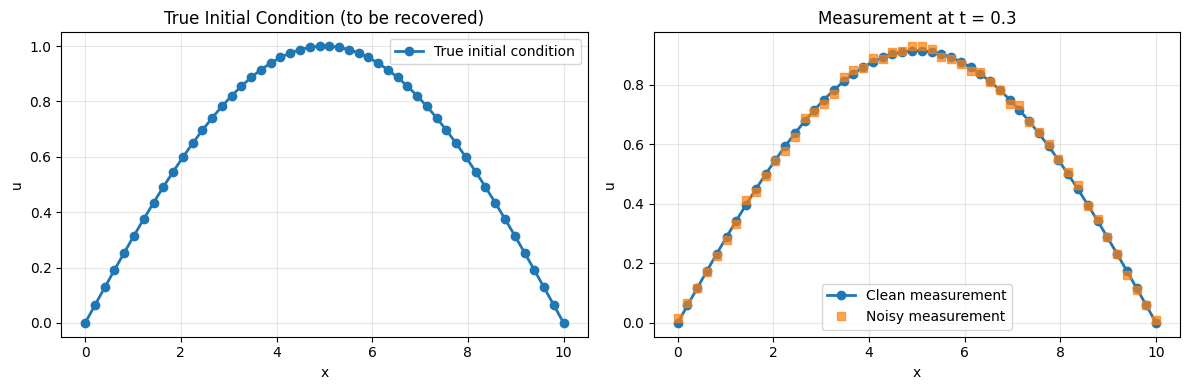

In [14]:
# ============================================================================
# 9. ADVANCED/OPTIONAL: INVERSE PROBLEM
# ============================================================================
# Goal: Recover initial condition from a measurement at later time

print("="*70)
print("INVERSE PROBLEM: RECONSTRUCTING INITIAL CONDITION")
print("="*70)

# ============================================================================
# Step 1: Generate synthetic measurement data
# ============================================================================

# Choose measurement time (try different values!)
t_measurement = 0.3  # Time when we "measure" the solution

print(f"\nGenerating synthetic measurement at t = {t_measurement}...")

# Number of measurement points
N_measure = 50
x_measure = jnp.linspace(0, L, N_measure)

# "True" initial condition (this is what we want to recover)
u_initial_true = jnp.sin(jnp.pi * x_measure / L)

# Simulated measurement at t_measurement (using analytical solution)
u_measured = jnp.sin(jnp.pi * x_measure / L) * jnp.exp(-D * (jnp.pi / L)**2 * t_measurement)

# Add some noise to make it realistic
noise_level = 0.01
key_noise = random.PRNGKey(123)
noise = noise_level * random.normal(key_noise, u_measured.shape)
u_measured_noisy = u_measured + noise

print(f"  Measurement points: {N_measure}")
print(f"  Noise level: {noise_level}")

# Visualize the data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_measure, u_initial_true, 'o-', label='True initial condition', linewidth=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('True Initial Condition (to be recovered)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(x_measure, u_measured, 'o-', label='Clean measurement', linewidth=2)
plt.plot(x_measure, u_measured_noisy, 's', label='Noisy measurement', alpha=0.7)
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Measurement at t = {t_measurement}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Initializing new PINN for inverse problem...

Training inverse PINN for 1000 epochs...
Learning rate: 0.0005


Training inverse PINN for 1000 epochs...
Learning rate: 0.0005



Epoch     0: L_total = 0.301936 | L_PDE = 0.023058 | L_BC = 0.062313 | L_data = 0.216565

Inverse training complete! Best loss: 0.000342

Inverse training complete! Best loss: 0.000342


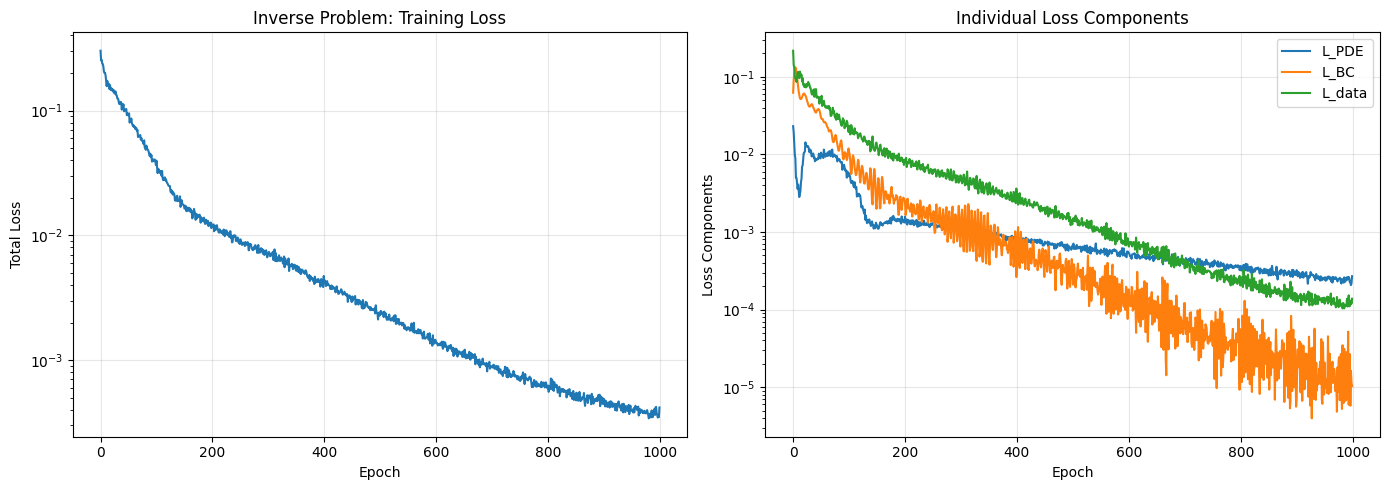

In [15]:
# ============================================================================
# Step 2: Create interpolation function for measurements
# ============================================================================

# Create interpolation function (cubic interpolation)
# Convert JAX arrays to NumPy for scipy compatibility
u_measured_interp = interp1d(np.array(x_measure), np.array(u_measured_noisy), 
                             kind='cubic', fill_value='extrapolate')

def loss_data(params, pinn, points_data, u_interp):
    """
    Loss for matching measurement data at t = t_measurement.
    Replaces L_IC in the inverse problem.
    """
    # Network predictions at measurement time
    predictions = pinn.neural_net(params, points_data)
    
    # Interpolated measurements at the same points
    x_coords = points_data[:, 0]
    u_measured_values = jnp.array([u_interp(x) for x in x_coords]).reshape(-1, 1)
    
    # Mean squared error
    return jnp.mean((predictions - u_measured_values)**2)


def total_loss_inverse(params, pinn, points_interior, points_boundary, 
                       points_data, D, L, u_interp):
    """
    Total loss for inverse problem: L_total = L_PDE + L_BC + L_data
    """
    l_pde = loss_pde(params, pinn, points_interior, D)
    l_bc = loss_bc(params, pinn, points_boundary)
    l_data = loss_data(params, pinn, points_data, u_interp)
    
    total = l_pde + l_bc + l_data
    
    return total, (l_pde, l_bc, l_data)


# ============================================================================
# Step 3: Train PINN for inverse problem
# ============================================================================

def train_pinn_inverse(pinn, geo, D, L, t_measurement, u_interp,
                       n_epochs=10000, N1=1000, N2=200, N_data=200, 
                       learning_rate=5e-4):
    """Train PINN for the inverse problem."""
    
    # Initialize optimizer (lower learning rate for stability)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(pinn.params)
    
    best_loss = float('inf')
    best_params = pinn.params
    
    loss_history = []
    loss_components = {'pde': [], 'bc': [], 'data': []}
    
    key = random.PRNGKey(42)
    
    print(f"\nTraining inverse PINN for {n_epochs} epochs...")
    print(f"Learning rate: {learning_rate}\n")
    
    for epoch in range(n_epochs):
        key, subkey1, subkey2, subkey3 = random.split(key, 4)
        
        # Sample interior and boundary points (throughout [0, t_measurement])
        points_interior = geo.sample_interior(subkey1, N1)
        points_boundary = geo.sample_boundary(subkey2, N2)
        
        # Sample data points at t = t_measurement
        points_data = geo.sample_at_time(subkey3, N_data, t_measurement)
        
        # Compute loss and gradients
        (loss_val, (l_pde, l_bc, l_data)), grads = jax.value_and_grad(
            total_loss_inverse, has_aux=True
        )(pinn.params, pinn, points_interior, points_boundary, 
          points_data, D, L, u_interp)
        
        # Update parameters
        updates, opt_state = optimizer.update(grads, opt_state)
        pinn.params = optax.apply_updates(pinn.params, updates)
        
        # Track best model
        if loss_val < best_loss:
            best_loss = loss_val
            best_params = pinn.params
        
        # Store history
        loss_history.append(loss_val)
        loss_components['pde'].append(l_pde)
        loss_components['bc'].append(l_bc)
        loss_components['data'].append(l_data)
        
        # Print progress
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}: L_total = {loss_val:.6f} | "
                  f"L_PDE = {l_pde:.6f} | L_BC = {l_bc:.6f} | L_data = {l_data:.6f}")
    
    print(f"\nInverse training complete! Best loss: {best_loss:.6f}")
    pinn.params = best_params
    
    return loss_history, loss_components


# Create new PINN for inverse problem
print("\nInitializing new PINN for inverse problem...")
layers_inverse = [2, 30, 30, 30, 1]  # Slightly larger network
key_inverse = random.PRNGKey(999)
pinn_inverse = Pinn(key_inverse, layers_inverse)

# Update geometry to only go up to t_measurement
geo_inverse = Geometry(L=L, N=100, t_start=0.0, t_end=t_measurement, Nt=50)

# Train
loss_history_inv, loss_components_inv = train_pinn_inverse(
    pinn_inverse, geo_inverse, D, L, t_measurement, u_measured_interp,
    n_epochs=1000, N1=1000, N2=200, N_data=200, learning_rate=5e-4
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(loss_history_inv, linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Inverse Problem: Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(loss_components_inv['pde'], label='L_PDE', linewidth=1.5)
axes[1].plot(loss_components_inv['bc'], label='L_BC', linewidth=1.5)
axes[1].plot(loss_components_inv['data'], label='L_data', linewidth=1.5)
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Components')
axes[1].set_title('Individual Loss Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




RECONSTRUCTION RESULTS

Reconstruction at t = 0 (going back 0.3 in time):
  Mean Absolute Error: 9.591436e-03
  Maximum Error:       1.966763e-02

Reconstruction at t = 0 (going back 0.3 in time):
  Mean Absolute Error: 9.591436e-03
  Maximum Error:       1.966763e-02


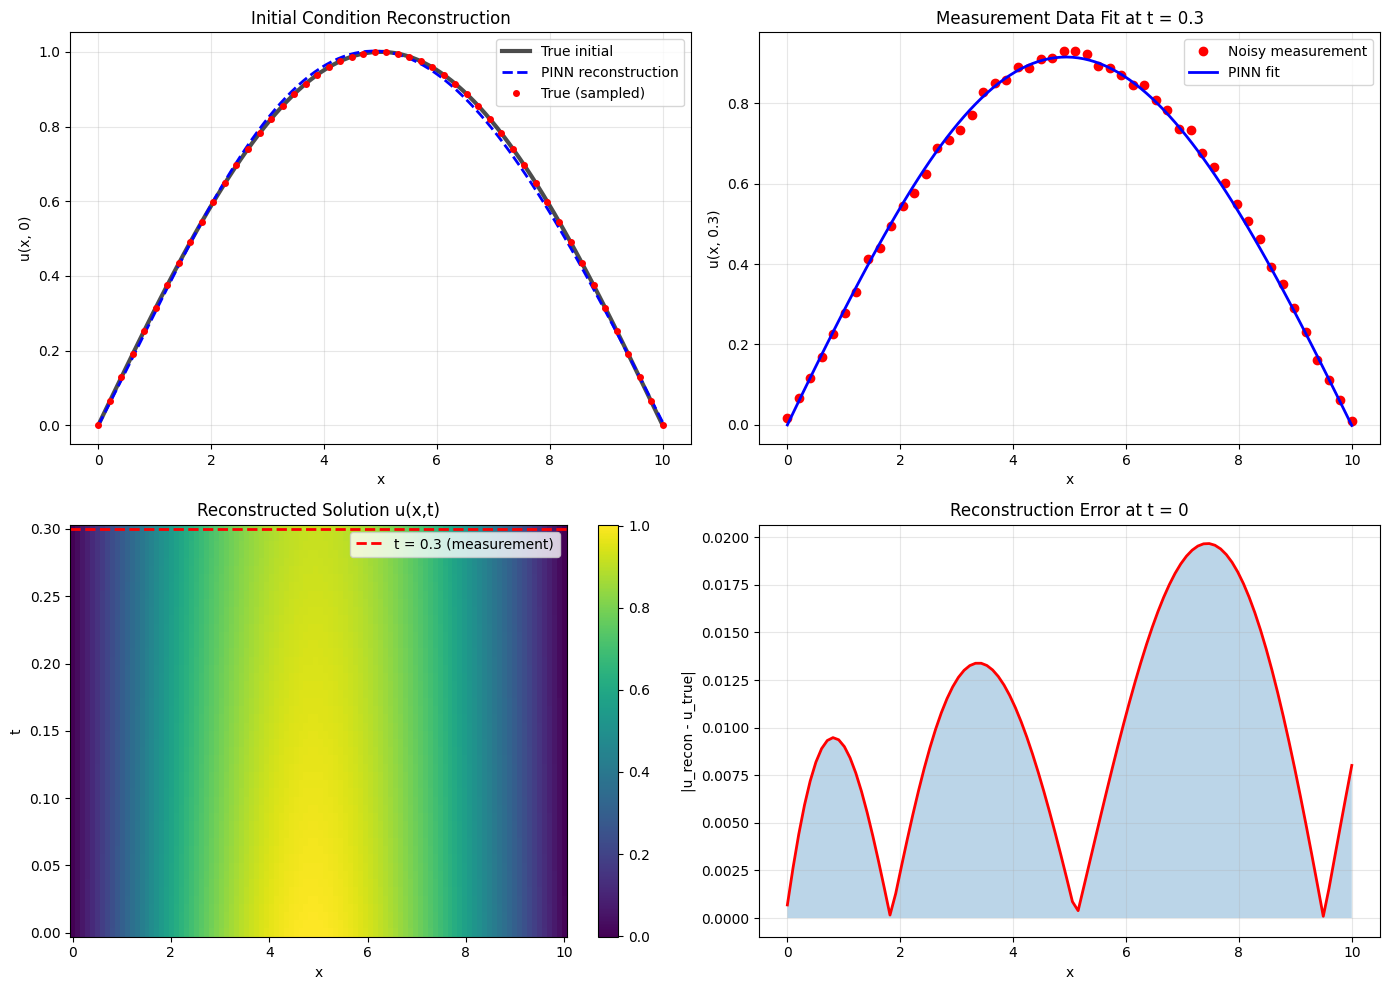


💡 Try changing t_measurement to see how reconstruction quality degrades!
   Current value: 0.3
   Suggested experiments: 0.1, 0.3, 0.5, 1.0, 2.0


In [16]:
# ============================================================================
# Step 4: Evaluate reconstruction
# ============================================================================

print("\n" + "="*70)
print("RECONSTRUCTION RESULTS")
print("="*70)

# Reconstruct initial condition
x_recon = jnp.linspace(0, L, 100)
t_zero = jnp.zeros_like(x_recon)
points_initial_recon = jnp.hstack((x_recon[:, None], t_zero[:, None]))
u_initial_reconstructed = pinn_inverse(points_initial_recon).flatten()

# True initial condition for comparison
u_initial_true_full = jnp.sin(jnp.pi * x_recon / L)

# Compute reconstruction error
recon_mae = jnp.mean(jnp.abs(u_initial_reconstructed - u_initial_true_full))
recon_max_error = jnp.max(jnp.abs(u_initial_reconstructed - u_initial_true_full))

print(f"\nReconstruction at t = 0 (going back {t_measurement} in time):")
print(f"  Mean Absolute Error: {recon_mae:.6e}")
print(f"  Maximum Error:       {recon_max_error:.6e}")
print("="*70)

# Visualize reconstruction
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Initial condition reconstruction
axes[0, 0].plot(x_recon, u_initial_true_full, 'k-', 
                label='True initial', linewidth=3, alpha=0.7)
axes[0, 0].plot(x_recon, u_initial_reconstructed, 'b--', 
                label='PINN reconstruction', linewidth=2)
axes[0, 0].plot(x_measure, u_initial_true, 'ro', 
                label='True (sampled)', markersize=4)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('u(x, 0)')
axes[0, 0].set_title('Initial Condition Reconstruction')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Measurement fit
x_meas_dense = jnp.linspace(0, L, 100)
t_meas_dense = jnp.full_like(x_meas_dense, t_measurement)
points_meas = jnp.hstack((x_meas_dense[:, None], t_meas_dense[:, None]))
u_meas_pred = pinn_inverse(points_meas).flatten()

axes[0, 1].plot(x_measure, u_measured_noisy, 'ro', 
                label='Noisy measurement', markersize=6)
axes[0, 1].plot(x_meas_dense, u_meas_pred, 'b-', 
                label='PINN fit', linewidth=2)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel(f'u(x, {t_measurement})')
axes[0, 1].set_title(f'Measurement Data Fit at t = {t_measurement}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Full solution in (x,t) space
x_full = geo_inverse.x
t_full = geo_inverse.t
X_full, T_full = jnp.meshgrid(x_full, t_full)
XT_full = jnp.hstack((X_full.flatten()[:, None], T_full.flatten()[:, None]))
u_inverse_full = pinn_inverse(XT_full).reshape(X_full.shape)

im = axes[1, 0].pcolormesh(X_full, T_full, u_inverse_full, shading='auto', cmap='viridis')
axes[1, 0].axhline(t_measurement, color='red', linestyle='--', 
                   linewidth=2, label=f't = {t_measurement} (measurement)')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('t')
axes[1, 0].set_title('Reconstructed Solution u(x,t)')
axes[1, 0].legend()
plt.colorbar(im, ax=axes[1, 0])

# 4. Reconstruction error
error_recon = jnp.abs(u_initial_reconstructed - u_initial_true_full)
axes[1, 1].plot(x_recon, error_recon, 'r-', linewidth=2)
axes[1, 1].fill_between(x_recon, 0, error_recon, alpha=0.3)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('|u_recon - u_true|')
axes[1, 1].set_title('Reconstruction Error at t = 0')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Try changing t_measurement to see how reconstruction quality degrades!")
print(f"   Current value: {t_measurement}")
print(f"   Suggested experiments: 0.1, 0.3, 0.5, 1.0, 2.0")

---

# 10. 🔬 ADVANCED: 2D Fricke Gel Inverse Problem

In this final advanced exercise, we extend our PINN capabilities to solve a realistic **2D inverse problem** inspired by medical physics: reconstructing the initial dose distribution in a Fricke gel dosimeter after diffusion has occurred.

## 10.1 Physical Background

**Fricke gel dosimeters** are used in radiation therapy to measure 3D dose distributions:
- Iron ions ($Fe^{2+}$) in gel are oxidized to $Fe^{3+}$ by ionizing radiation
- $Fe^{3+}$ concentration is proportional to absorbed dose
- MRI or optical scanning can map the $Fe^{3+}$ distribution

**The Challenge:** 
- Diffusion blurs the dose distribution between irradiation and measurement
- We measure a *diffused* distribution, but need the *original* dose for treatment verification
- This is an **inverse problem**: going backward in time to recover initial conditions

**Governing Equation (2D Heat/Diffusion):**

$$\frac{\partial u}{\partial t} = D \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)$$

Where:
- $u(x,y,t)$ is the $Fe^{3+}$ concentration (proportional to dose)
- $D$ is the diffusion coefficient
- Domain: $(x,y) \in [0, L_x] \times [0, L_y]$, $t \in [0, T_{max}]$
- Boundary conditions: Neumann (no-flux) at all boundaries

**Our Goal:** Given $u(x,y,T_{measure})$ (measurement after diffusion), reconstruct $u(x,y,0)$ (original dose distribution)

---

2D FRICKE GEL INVERSE PROBLEM - DATA GENERATION

Domain: 1.0 x 1.0
Diffusion coefficient: D = 0.005
Spatial resolution: dx = 0.01, dy = 0.01
Grid size: (100, 100)


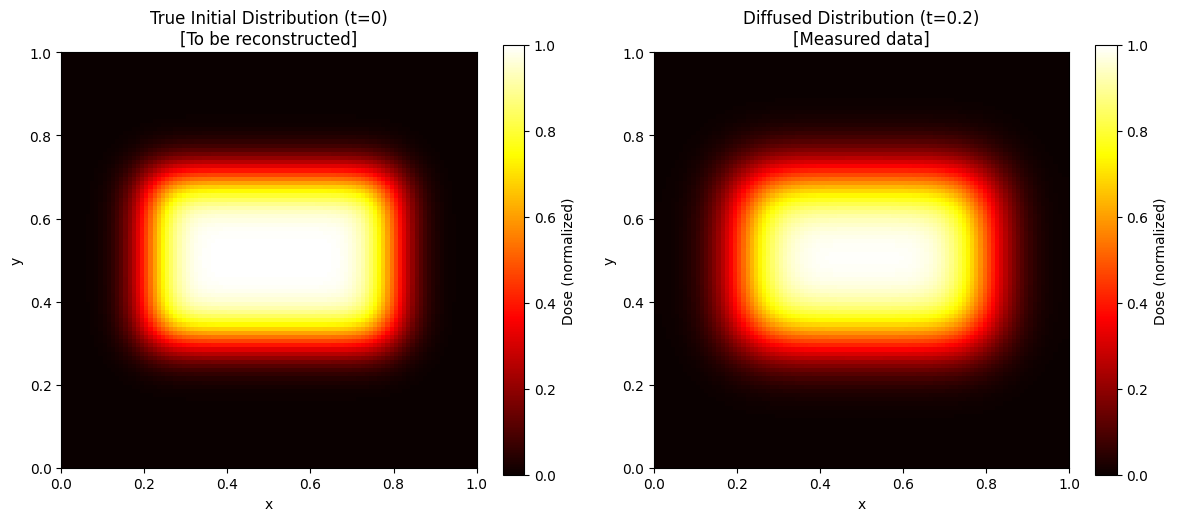


Data generated successfully!
Initial distribution range: [0.0000, 0.9996]
Diffused distribution range: [0.0000, 0.9941]


In [17]:
# ============================================================================
# 10.2 Generate Synthetic 2D Data using FTCS
# ============================================================================

print("="*70)
print("2D FRICKE GEL INVERSE PROBLEM - DATA GENERATION")
print("="*70)

from FTCS.FTCS_scheme import diffusion_2D
from FTCS.Initial_condition import rectangle

# Problem parameters
Lx = 1.0      # domain size in x
Ly = 1.0      # domain size in y
Tmax = 0.5    # maximum time
D_2d = 0.005  # diffusion coefficient
dx = 0.01     # spatial resolution x
dy = 0.01     # spatial resolution y

# Rectangle initial condition parameters (dose distribution)
xc = 0.5      # center x
yc = 0.5      # center y
W = 0.3       # width
H = 0.2       # height

print(f"\nDomain: {Lx} x {Ly}")
print(f"Diffusion coefficient: D = {D_2d}")
print(f"Spatial resolution: dx = {dx}, dy = {dy}")

# Initialize FTCS solver
geo_ftcs = diffusion_2D(Lx, Ly, Tmax, dx, dy, D_2d)

# Create smooth rectangular initial condition
ini_2d = rectangle(geo_ftcs, xc, yc, H, W, T_evo=0.3)
geo_ftcs.set_initial_condition(ini_2d)

print(f"Grid size: {ini_2d.shape}")

# Visualize initial condition
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(ini_2d, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
plt.colorbar(label='Dose (normalized)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True Initial Distribution (t=0)\n[To be reconstructed]')

# Evolve to measurement time
t_measure_2d = 0.2  # measurement time
geo_ftcs_measure = diffusion_2D(Lx, Ly, t_measure_2d, dx, dy, D_2d)
geo_ftcs_measure.set_initial_condition(ini_2d)
final_2d = geo_ftcs_measure.Neumann_evo()

plt.subplot(1, 2, 2)
plt.imshow(final_2d, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
plt.colorbar(label='Dose (normalized)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Diffused Distribution (t={t_measure_2d})\n[Measured data]')

plt.tight_layout()
plt.show()

print(f"\nData generated successfully!")
print(f"Initial distribution range: [{ini_2d.min():.4f}, {ini_2d.max():.4f}]")
print(f"Diffused distribution range: [{final_2d.min():.4f}, {final_2d.max():.4f}]")

## 10.3 2D Geometry Class for PINN

We need to extend our geometry class to handle 2D spatial domains. The main differences from 1D:
- Input coordinates: $(x, y, t)$ instead of $(x, t)$
- Domain boundaries: 4 edges (left, right, bottom, top) instead of 2 points
- Neumann boundary conditions: $\frac{\partial u}{\partial n} = 0$ at all boundaries

In [18]:
# ============================================================================
# 2D Geometry class for spatial domain [0, Lx] x [0, Ly] x [0, T]
# ============================================================================

class Geometry2D:
    """
    Geometry class for 2D spatial + 1D temporal domain.
    Domain: (x,y) ∈ [0, Lx] x [0, Ly], t ∈ [t_start, t_end]
    """
    def __init__(self, Lx=1.0, Ly=1.0, Nx=50, Ny=50, t_start=0.0, t_end=1.0, Nt=50):
        self.Lx = Lx
        self.Ly = Ly
        self.Nx = Nx
        self.Ny = Ny
        self.t_start = t_start
        self.t_end = t_end
        self.Nt = Nt
        
        # Create grids for visualization
        self.x = jnp.linspace(0, Lx, Nx)
        self.y = jnp.linspace(0, Ly, Ny)
        self.t = jnp.linspace(t_start, t_end, Nt)
    
    def sample_interior(self, key, N):
        """Sample N random points in the interior domain."""
        key_x, key_y, key_t = random.split(key, 3)
        x = random.uniform(key_x, (N, 1), minval=0.0, maxval=self.Lx)
        y = random.uniform(key_y, (N, 1), minval=0.0, maxval=self.Ly)
        t = random.uniform(key_t, (N, 1), minval=self.t_start, maxval=self.t_end)
        return jnp.hstack((x, y, t))
    
    def sample_boundary(self, key, N):
        """Sample N random points on the 4 spatial boundaries."""
        # Split among 4 boundaries
        N_per_edge = N // 4
        keys = random.split(key, 4)
        
        # Left boundary (x=0)
        y_left = random.uniform(keys[0], (N_per_edge,), minval=0.0, maxval=self.Ly)
        t_left = random.uniform(keys[0], (N_per_edge,), minval=self.t_start, maxval=self.t_end)
        left = jnp.column_stack((jnp.zeros(N_per_edge), y_left, t_left))
        
        # Right boundary (x=Lx)
        y_right = random.uniform(keys[1], (N_per_edge,), minval=0.0, maxval=self.Ly)
        t_right = random.uniform(keys[1], (N_per_edge,), minval=self.t_start, maxval=self.t_end)
        right = jnp.column_stack((jnp.full(N_per_edge, self.Lx), y_right, t_right))
        
        # Bottom boundary (y=0)
        x_bottom = random.uniform(keys[2], (N_per_edge,), minval=0.0, maxval=self.Lx)
        t_bottom = random.uniform(keys[2], (N_per_edge,), minval=self.t_start, maxval=self.t_end)
        bottom = jnp.column_stack((x_bottom, jnp.zeros(N_per_edge), t_bottom))
        
        # Top boundary (y=Ly)
        x_top = random.uniform(keys[3], (N_per_edge,), minval=0.0, maxval=self.Lx)
        t_top = random.uniform(keys[3], (N_per_edge,), minval=self.t_start, maxval=self.t_end)
        top = jnp.column_stack((x_top, jnp.full(N_per_edge, self.Ly), t_top))
        
        return jnp.vstack((left, right, bottom, top))
    
    def sample_initial(self, key, N):
        """Sample N random points at initial time t=0."""
        key_x, key_y = random.split(key)
        x = random.uniform(key_x, (N, 1), minval=0.0, maxval=self.Lx)
        y = random.uniform(key_y, (N, 1), minval=0.0, maxval=self.Ly)
        t = jnp.zeros((N, 1))
        return jnp.hstack((x, y, t))
    
    def sample_at_time(self, key, N, t_val):
        """Sample N random points at specific time t_val."""
        key_x, key_y = random.split(key)
        x = random.uniform(key_x, (N, 1), minval=0.0, maxval=self.Lx)
        y = random.uniform(key_y, (N, 1), minval=0.0, maxval=self.Ly)
        t = jnp.full((N, 1), t_val)
        return jnp.hstack((x, y, t))

print("✓ Geometry2D class defined")

✓ Geometry2D class defined


## 10.4 2D Neural Network Architecture

The PINN for 2D diffusion has:
- **Input:** 3 coordinates $(x, y, t)$
- **Output:** 1 value $u(x, y, t)$
- **Architecture:** Similar to 1D but may need more capacity for 2D spatial patterns

In [19]:
# ============================================================================
# 2D PINN Architecture
# ============================================================================

class Pinn2D:
    """
    Physics-Informed Neural Network for 2D diffusion equation.
    Input: (x, y, t) - 3D
    Output: u(x, y, t) - scalar
    """
    def __init__(self, key, layer_sizes):
        """
        Initialize 2D PINN with random weights.
        
        Parameters:
        -----------
        key : jax.random.PRNGKey
        layer_sizes : list
            e.g., [3, 50, 50, 50, 1] for 3 inputs, 3 hidden layers of 50, 1 output
        """
        self.layer_sizes = layer_sizes
        self.params = self.initialize_network(key, layer_sizes)
    
    def initialize_network(self, key, layer_sizes):
        """Initialize network parameters using Xavier initialization."""
        params = []
        for i in range(len(layer_sizes) - 1):
            key, subkey = random.split(key)
            n_in, n_out = layer_sizes[i], layer_sizes[i + 1]
            # Xavier initialization
            std = jnp.sqrt(2.0 / (n_in + n_out))
            W = std * random.normal(subkey, (n_in, n_out))
            b = jnp.zeros(n_out)
            params.append({'W': W, 'b': b})
        return params
    
    def neural_net(self, params, X):
        """Forward pass through the network."""
        activations = X
        # Hidden layers with tanh activation
        for i in range(len(params) - 1):
            activations = jnp.tanh(jnp.dot(activations, params[i]['W']) + params[i]['b'])
        # Output layer (linear)
        output = jnp.dot(activations, params[-1]['W']) + params[-1]['b']
        return output
    
    def __call__(self, points):
        """Evaluate network at given points."""
        return self.neural_net(self.params, points)

print("✓ Pinn2D class defined")

✓ Pinn2D class defined


## 10.5 Loss Functions for 2D Inverse Problem

For the 2D Fricke gel inverse problem, we need:

1. **PDE Loss** - Enforce 2D diffusion equation:
   $$\mathcal{L}_{PDE} = \left| \frac{\partial u}{\partial t} - D \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \right|^2$$

2. **Boundary Loss** - Enforce Neumann (no-flux) boundary conditions:
   $$\mathcal{L}_{BC} = \left| \frac{\partial u}{\partial n} \right|^2 \text{ at boundaries}$$

3. **Data Loss** - Match measurement at $t = T_{measure}$:
   $$\mathcal{L}_{data} = \left| u(x,y,T_{measure}) - u_{measured}(x,y) \right|^2$$

Note: We replace the initial condition loss with data loss (inverse problem strategy).

In [20]:
# ============================================================================
# Loss Functions for 2D Inverse Problem
# ============================================================================

def loss_pde_2d(params, pinn, points, D):
    """
    PDE residual loss for 2D diffusion equation.
    PDE: du/dt = D * (d²u/dx² + d²u/dy²)
    """
    # Define function for automatic differentiation
    def u_fn(x, y, t):
        point = jnp.array([[x, y, t]])
        return pinn.neural_net(params, point)[0, 0]
    
    # Compute derivatives using JAX
    def compute_residual(point):
        x, y, t = point[0], point[1], point[2]
        
        # First derivatives
        du_dt = grad(lambda t_: u_fn(x, y, t_))(t)
        
        # Second derivatives in space
        du_dxx = grad(grad(lambda x_: u_fn(x_, y, t)))(x)
        du_dyy = grad(grad(lambda y_: u_fn(x, y_, t)))(y)
        
        # PDE residual
        residual = du_dt - D * (du_dxx + du_dyy)
        return residual ** 2
    
    # Vectorize over all points
    residuals = vmap(compute_residual)(points)
    return jnp.mean(residuals)


def loss_bc_neumann_2d(params, pinn, points):
    """
    Neumann boundary condition loss: du/dn = 0 at all boundaries.
    We need to compute normal derivatives at each boundary.
    """
    def u_fn(x, y, t):
        point = jnp.array([[x, y, t]])
        return pinn.neural_net(params, point)[0, 0]
    
    def compute_normal_derivative(point):
        x, y, t = point[0], point[1], point[2]
        
        # Determine which boundary this point is on
        # Left (x≈0): normal derivative is -du/dx
        # Right (x≈Lx): normal derivative is du/dx
        # Bottom (y≈0): normal derivative is -du/dy
        # Top (y≈Ly): normal derivative is du/dy
        
        du_dx = grad(lambda x_: u_fn(x_, y, t))(x)
        du_dy = grad(lambda y_: u_fn(x, y_, t))(y)
        
        # For simplicity, penalize both derivatives at boundaries
        # This enforces zero normal derivative regardless of which edge
        return du_dx ** 2 + du_dy ** 2
    
    # Vectorize over all boundary points
    bc_residuals = vmap(compute_normal_derivative)(points)
    return jnp.mean(bc_residuals)


def create_measurement_interpolator(x_grid, y_grid, u_measured):
    """
    Create an interpolation function for 2D measured data.
    Uses scipy's RegularGridInterpolator converted to JAX-compatible format.
    """
    from scipy.interpolate import RegularGridInterpolator
    
    # Create scipy interpolator
    interp = RegularGridInterpolator(
        (x_grid, y_grid), 
        u_measured.T,  # Transpose because of array indexing convention
        method='cubic',
        bounds_error=False,
        fill_value=0.0
    )
    
    def interpolate_jax(x, y):
        """JAX-compatible interpolation function."""
        # Convert to numpy for scipy, then back to jax
        points = np.column_stack((np.array(x), np.array(y)))
        values = interp(points)
        return jnp.array(values)
    
    return interpolate_jax


def loss_data_2d(params, pinn, points, u_interp_fn):
    """
    Data loss: match measurements at t = t_measurement.
    """
    # Network predictions
    predictions = pinn.neural_net(params, points).flatten()
    
    # Interpolated measurements at the same spatial locations
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    u_measured_values = u_interp_fn(x_coords, y_coords)
    
    # Mean squared error
    return jnp.mean((predictions - u_measured_values) ** 2)


def total_loss_2d_inverse(params, pinn, points_interior, points_boundary, 
                          points_data, D, u_interp_fn, 
                          w_pde=1.0, w_bc=1.0, w_data=10.0):
    """
    Total loss for 2D inverse problem.
    Includes weighting for different loss components.
    """
    l_pde = w_pde * loss_pde_2d(params, pinn, points_interior, D)
    l_bc = w_bc * loss_bc_neumann_2d(params, pinn, points_boundary)
    l_data = w_data * loss_data_2d(params, pinn, points_data, u_interp_fn)
    
    total = l_pde + l_bc + l_data
    return total, (l_pde, l_bc, l_data)

print("✓ Loss functions defined")

✓ Loss functions defined


## 10.6 Training the 2D Inverse PINN

Now we set up the data interpolator and train the PINN to solve the inverse problem.

In [21]:
# ============================================================================
# 10.6 Prepare data and interpolator
# ============================================================================

print("\n" + "="*70)
print("PREPARING DATA INTERPOLATOR")
print("="*70)

# Create coordinate grids matching the FTCS data
x_ftcs = np.linspace(0, Lx, final_2d.shape[1])
y_ftcs = np.linspace(0, Ly, final_2d.shape[0])

print(f"FTCS data shape: {final_2d.shape}")
print(f"x grid: {len(x_ftcs)} points from 0 to {Lx}")
print(f"y grid: {len(y_ftcs)} points from 0 to {Ly}")

# Create interpolator for measured data
u_interp_2d = create_measurement_interpolator(x_ftcs, y_ftcs, final_2d)

# Test interpolation
test_x = jnp.array([0.5, 0.3, 0.7])
test_y = jnp.array([0.5, 0.4, 0.6])
test_vals = u_interp_2d(test_x, test_y)
print(f"\nInterpolation test at (0.5, 0.5): {test_vals[0]:.6f}")

print("✓ Data interpolator ready")


PREPARING DATA INTERPOLATOR
FTCS data shape: (100, 100)
x grid: 100 points from 0 to 1.0
y grid: 100 points from 0 to 1.0

Interpolation test at (0.5, 0.5): 0.993932
✓ Data interpolator ready


In [22]:
# ============================================================================
# Initialize 2D PINN and Geometry
# ============================================================================

print("\n" + "="*70)
print("INITIALIZING 2D PINN")
print("="*70)

# Initialize geometry for training (from t=0 to t_measurement)
geo_2d = Geometry2D(Lx=Lx, Ly=Ly, Nx=50, Ny=50, 
                    t_start=0.0, t_end=t_measure_2d, Nt=25)

# Initialize PINN with larger architecture for 2D
layer_sizes_2d = [3, 64, 64, 64, 1]  # 3 inputs (x,y,t), 1 output (u)
key_2d = random.PRNGKey(42)
pinn_2d = Pinn2D(key_2d, layer_sizes_2d)

print(f"Network architecture: {layer_sizes_2d}")
print(f"Total parameters: {sum(p['W'].size + p['b'].size for p in pinn_2d.params)}")
print(f"Time domain: [0, {t_measure_2d}]")
print("✓ PINN initialized")


INITIALIZING 2D PINN
Network architecture: [3, 64, 64, 64, 1]
Total parameters: 8641
Time domain: [0, 0.2]
✓ PINN initialized
Network architecture: [3, 64, 64, 64, 1]
Total parameters: 8641
Time domain: [0, 0.2]
✓ PINN initialized


In [23]:
# ============================================================================
# Training Loop for 2D Inverse Problem
# ============================================================================

import optax

def train_pinn_2d_inverse(pinn, geo, D, u_interp_fn, 
                          n_epochs=5000,
                          N_interior=2000, 
                          N_boundary=400, 
                          N_data=500,
                          learning_rate=1e-3,
                          w_pde=1.0, w_bc=1.0, w_data=10.0):
    """
    Train 2D PINN for inverse problem.
    """
    # Initialize optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(pinn.params)
    
    loss_history = []
    loss_components = {'pde': [], 'bc': [], 'data': []}
    
    key = random.PRNGKey(123)
    
    print(f"\n{'='*70}")
    print(f"TRAINING 2D INVERSE PINN")
    print(f"{'='*70}")
    print(f"Epochs: {n_epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights - PDE: {w_pde}, BC: {w_bc}, Data: {w_data}")
    print(f"Sample sizes - Interior: {N_interior}, Boundary: {N_boundary}, Data: {N_data}")
    print()
    
    for epoch in range(n_epochs):
        # Generate random samples
        key, *subkeys = random.split(key, 4)
        points_interior = geo.sample_interior(subkeys[0], N_interior)
        points_boundary = geo.sample_boundary(subkeys[1], N_boundary)
        points_data = geo.sample_at_time(subkeys[2], N_data, t_measure_2d)
        
        # Compute loss and gradients
        (loss_val, (l_pde, l_bc, l_data)), grads = jax.value_and_grad(
            total_loss_2d_inverse, has_aux=True
        )(pinn.params, pinn, points_interior, points_boundary, 
          points_data, D, u_interp_fn, w_pde, w_bc, w_data)
        
        # Update parameters
        updates, opt_state = optimizer.update(grads, opt_state)
        pinn.params = optax.apply_updates(pinn.params, updates)
        
        # Store history
        loss_history.append(loss_val)
        loss_components['pde'].append(l_pde)
        loss_components['bc'].append(l_bc)
        loss_components['data'].append(l_data)
        
        # Print progress
        if epoch % 500 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch:5d}: L_total = {loss_val:.6f} | "
                  f"L_PDE = {l_pde:.6f} | L_BC = {l_bc:.6f} | L_data = {l_data:.6f}")
    
    print(f"\n{'='*70}")
    print("TRAINING COMPLETE")
    print(f"{'='*70}\n")
    
    return loss_history, loss_components


# Train the model
loss_history_2d, loss_components_2d = train_pinn_2d_inverse(
    pinn_2d, geo_2d, D_2d, u_interp_2d,
    n_epochs=5000,
    N_interior=2000,
    N_boundary=400, 
    N_data=500,
    learning_rate=1e-3,
    w_pde=1.0,
    w_bc=1.0, 
    w_data=10.0
)


TRAINING 2D INVERSE PINN
Epochs: 5000
Learning rate: 0.001
Loss weights - PDE: 1.0, BC: 1.0, Data: 10.0
Sample sizes - Interior: 2000, Boundary: 400, Data: 500

Epoch     0: L_total = 3.507002 | L_PDE = 0.171901 | L_BC = 0.037978 | L_data = 3.297123
Epoch     0: L_total = 3.507002 | L_PDE = 0.171901 | L_BC = 0.037978 | L_data = 3.297123
Epoch   500: L_total = 0.739716 | L_PDE = 0.021833 | L_BC = 0.115529 | L_data = 0.602353
Epoch   500: L_total = 0.739716 | L_PDE = 0.021833 | L_BC = 0.115529 | L_data = 0.602353
Epoch  1000: L_total = 0.094672 | L_PDE = 0.006314 | L_BC = 0.024795 | L_data = 0.063563
Epoch  1000: L_total = 0.094672 | L_PDE = 0.006314 | L_BC = 0.024795 | L_data = 0.063563


KeyboardInterrupt: 

NameError: name 'loss_history_2d' is not defined

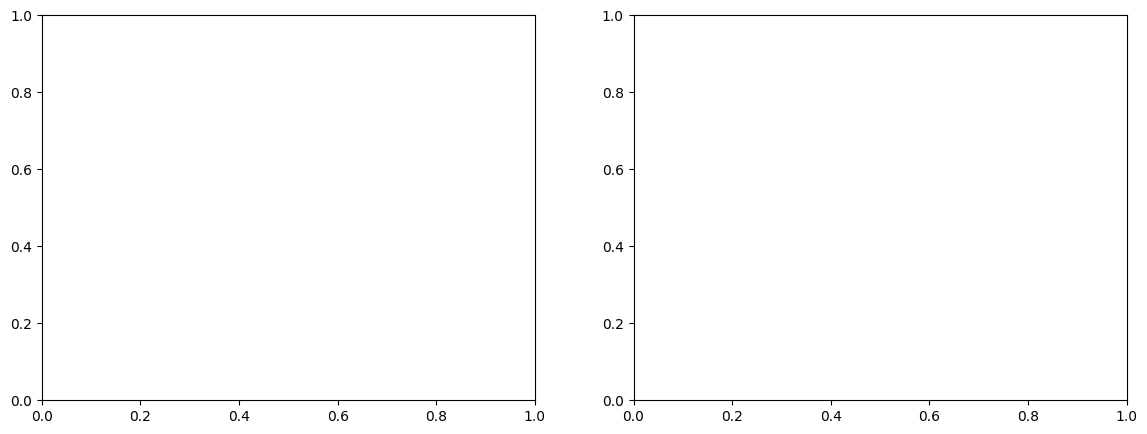

In [24]:
# ============================================================================
# Visualize Training History
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total loss
axes[0].plot(loss_history_2d, linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('2D Inverse Problem: Training Loss')
axes[0].grid(True, alpha=0.3)

# Loss components
axes[1].plot(loss_components_2d['pde'], label='L_PDE', linewidth=1.5, alpha=0.8)
axes[1].plot(loss_components_2d['bc'], label='L_BC', linewidth=1.5, alpha=0.8)
axes[1].plot(loss_components_2d['data'], label='L_data', linewidth=1.5, alpha=0.8)
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Components')
axes[1].set_title('Individual Loss Terms')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10.7 Reconstruction Results

Now we evaluate the PINN's ability to reconstruct the initial dose distribution.

In [25]:
# ============================================================================
# Reconstruct Initial Condition
# ============================================================================

print("\n" + "="*70)
print("RECONSTRUCTING INITIAL CONDITION")
print("="*70)

# Create evaluation grid at t=0
Nx_eval = 100
Ny_eval = 100
x_eval = jnp.linspace(0, Lx, Nx_eval)
y_eval = jnp.linspace(0, Ly, Ny_eval)
X_eval, Y_eval = jnp.meshgrid(x_eval, y_eval)

# Flatten for network evaluation
x_flat = X_eval.flatten()
y_flat = Y_eval.flatten()
t_flat = jnp.zeros_like(x_flat)  # t = 0 for initial condition
points_t0 = jnp.column_stack((x_flat, y_flat, t_flat))

# Predict initial condition
print("Evaluating PINN at t=0...")
u_reconstructed = pinn_2d(points_t0).reshape(Nx_eval, Ny_eval)

# Also evaluate at measurement time for comparison
t_meas_flat = jnp.full_like(x_flat, t_measure_2d)
points_tmeas = jnp.column_stack((x_flat, y_flat, t_meas_flat))
u_at_measurement = pinn_2d(points_tmeas).reshape(Nx_eval, Ny_eval)

print("✓ Reconstruction complete")

# Compute errors
# Interpolate true initial condition to evaluation grid
from scipy.interpolate import RectBivariateSpline
ini_interp = RectBivariateSpline(
    np.linspace(0, Ly, ini_2d.shape[0]),
    np.linspace(0, Lx, ini_2d.shape[1]),
    ini_2d
)
u_true_initial_eval = jnp.array(ini_interp(y_eval, x_eval))

# Compute metrics
mae_recon = jnp.mean(jnp.abs(u_reconstructed - u_true_initial_eval))
mse_recon = jnp.mean((u_reconstructed - u_true_initial_eval) ** 2)
max_error_recon = jnp.max(jnp.abs(u_reconstructed - u_true_initial_eval))

print(f"\nReconstruction Metrics:")
print(f"  Mean Absolute Error: {mae_recon:.6f}")
print(f"  Mean Squared Error:  {mse_recon:.6f}")
print(f"  Maximum Error:       {max_error_recon:.6f}")
print(f"  Relative MAE:        {mae_recon / jnp.mean(u_true_initial_eval):.2%}")
print("="*70)


RECONSTRUCTING INITIAL CONDITION
Evaluating PINN at t=0...
✓ Reconstruction complete

Reconstruction Metrics:
  Mean Absolute Error: 0.059582
  Mean Squared Error:  0.006873
  Maximum Error:       0.310042
  Relative MAE:        25.89%
✓ Reconstruction complete

Reconstruction Metrics:
  Mean Absolute Error: 0.059582
  Mean Squared Error:  0.006873
  Maximum Error:       0.310042
  Relative MAE:        25.89%


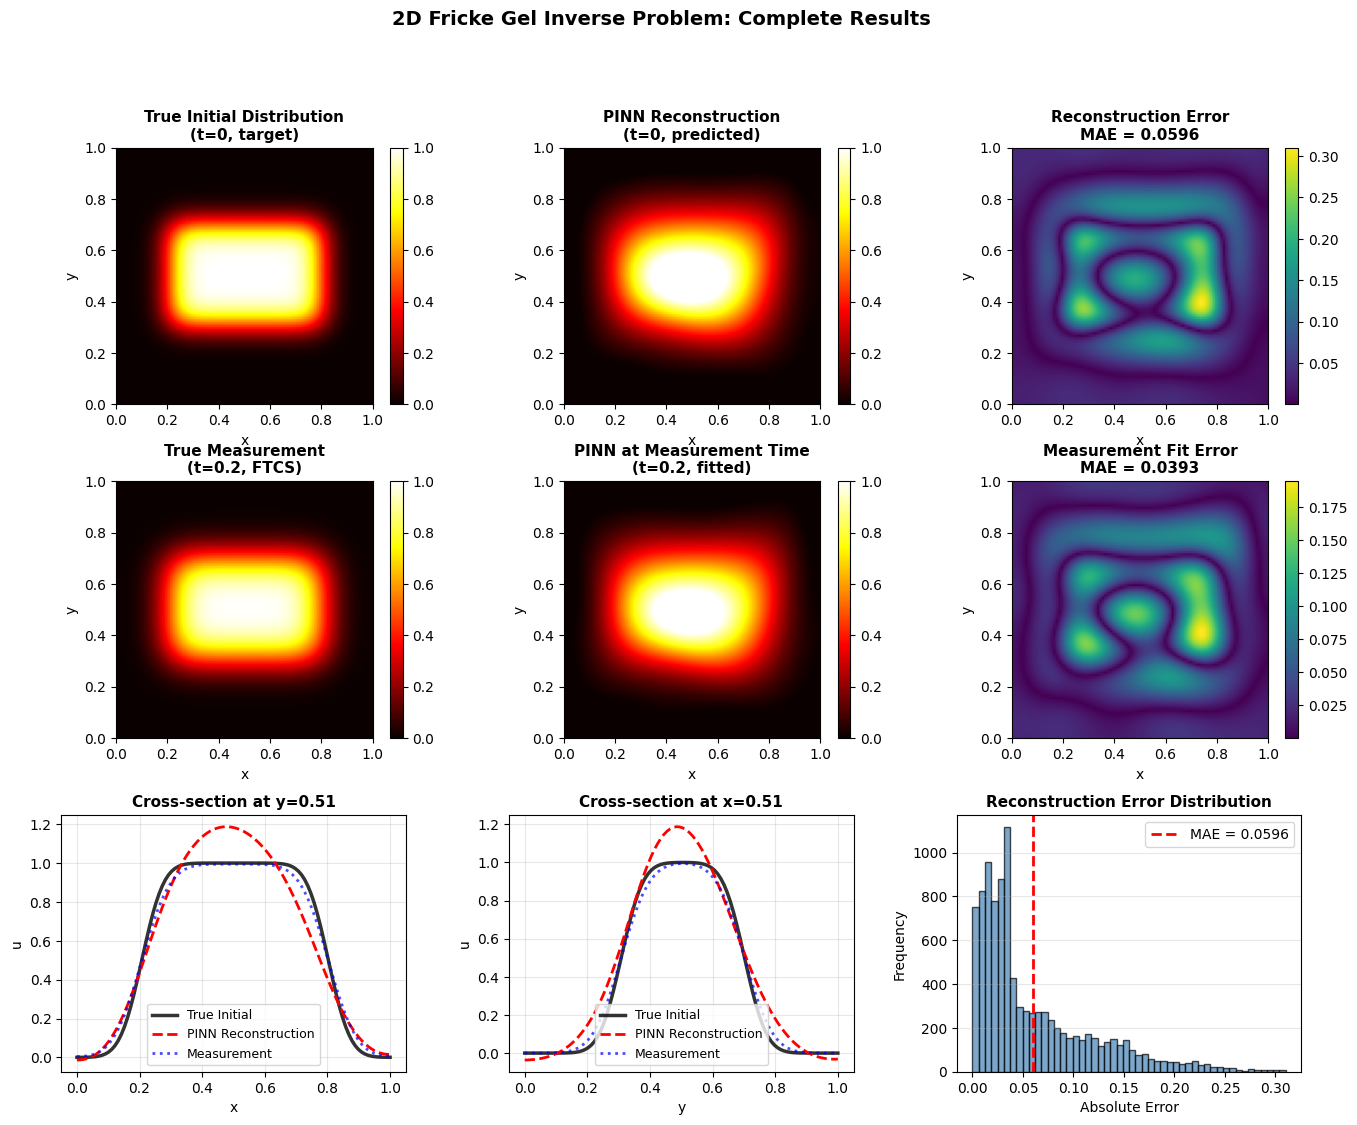

In [26]:
# ============================================================================
# Comprehensive Visualization
# ============================================================================

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Initial condition (true, reconstructed, error)
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(u_true_initial_eval, cmap='hot', origin='lower', 
                 extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('True Initial Distribution\n(t=0, target)', fontsize=11, fontweight='bold')
plt.colorbar(im1, ax=ax1, fraction=0.046)

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(u_reconstructed, cmap='hot', origin='lower', 
                 extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('PINN Reconstruction\n(t=0, predicted)', fontsize=11, fontweight='bold')
plt.colorbar(im2, ax=ax2, fraction=0.046)

ax3 = fig.add_subplot(gs[0, 2])
error_initial = np.abs(u_reconstructed - u_true_initial_eval)
im3 = ax3.imshow(error_initial, cmap='viridis', origin='lower', extent=[0, Lx, 0, Ly])
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title(f'Reconstruction Error\nMAE = {mae_recon:.4f}', fontsize=11, fontweight='bold')
plt.colorbar(im3, ax=ax3, fraction=0.046)

# Row 2: Measurement time comparison
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(final_2d, cmap='hot', origin='lower', 
                 extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title(f'True Measurement\n(t={t_measure_2d}, FTCS)', fontsize=11, fontweight='bold')
plt.colorbar(im4, ax=ax4, fraction=0.046)

ax5 = fig.add_subplot(gs[1, 1])
im5 = ax5.imshow(u_at_measurement, cmap='hot', origin='lower', 
                 extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_title(f'PINN at Measurement Time\n(t={t_measure_2d}, fitted)', fontsize=11, fontweight='bold')
plt.colorbar(im5, ax=ax5, fraction=0.046)

ax6 = fig.add_subplot(gs[1, 2])
# Interpolate final_2d to evaluation grid for comparison
final_interp = RectBivariateSpline(
    np.linspace(0, Ly, final_2d.shape[0]),
    np.linspace(0, Lx, final_2d.shape[1]),
    final_2d
)
final_2d_eval = jnp.array(final_interp(y_eval, x_eval))
error_measurement = np.abs(u_at_measurement - final_2d_eval)
im6 = ax6.imshow(error_measurement, cmap='viridis', origin='lower', extent=[0, Lx, 0, Ly])
ax6.set_xlabel('x')
ax6.set_ylabel('y')
mae_meas = jnp.mean(error_measurement)
ax6.set_title(f'Measurement Fit Error\nMAE = {mae_meas:.4f}', fontsize=11, fontweight='bold')
plt.colorbar(im6, ax=ax6, fraction=0.046)

# Row 3: Cross-sections and diffusion visualization
ax7 = fig.add_subplot(gs[2, 0])
mid_y_idx = Ny_eval // 2
ax7.plot(x_eval, u_true_initial_eval[mid_y_idx, :], 'k-', 
         label='True Initial', linewidth=2.5, alpha=0.8)
ax7.plot(x_eval, u_reconstructed[mid_y_idx, :], 'r--', 
         label='PINN Reconstruction', linewidth=2)
ax7.plot(x_eval, final_2d_eval[mid_y_idx, :], 'b:', 
         label='Measurement', linewidth=2, alpha=0.7)
ax7.set_xlabel('x')
ax7.set_ylabel('u')
ax7.set_title(f'Cross-section at y={y_eval[mid_y_idx]:.2f}', fontsize=11, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
mid_x_idx = Nx_eval // 2
ax8.plot(y_eval, u_true_initial_eval[:, mid_x_idx], 'k-', 
         label='True Initial', linewidth=2.5, alpha=0.8)
ax8.plot(y_eval, u_reconstructed[:, mid_x_idx], 'r--', 
         label='PINN Reconstruction', linewidth=2)
ax8.plot(y_eval, final_2d_eval[:, mid_x_idx], 'b:', 
         label='Measurement', linewidth=2, alpha=0.7)
ax8.set_xlabel('y')
ax8.set_ylabel('u')
ax8.set_title(f'Cross-section at x={x_eval[mid_x_idx]:.2f}', fontsize=11, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)

# Error histogram
ax9 = fig.add_subplot(gs[2, 2])
ax9.hist(error_initial.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax9.axvline(mae_recon, color='red', linestyle='--', linewidth=2, label=f'MAE = {mae_recon:.4f}')
ax9.set_xlabel('Absolute Error')
ax9.set_ylabel('Frequency')
ax9.set_title('Reconstruction Error Distribution', fontsize=11, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.suptitle('2D Fricke Gel Inverse Problem: Complete Results', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

## 10.8 Key Observations and Extensions

### 🎯 What We Accomplished

1. **Solved a realistic 2D inverse problem** - Reconstructed initial dose distribution from diffused measurements
2. **Used existing simulation tools** - Leveraged FTCS module for ground truth data generation
3. **Implemented JAX-based PINN** - Custom architecture consistent with the notebook's approach
4. **Enforced physical constraints** - PDE and Neumann boundary conditions built into the loss

### 🔬 Physical Insights

- **Diffusion blurs information**: The longer the time between irradiation and measurement, the harder reconstruction becomes
- **Inverse problems are ill-posed**: Small changes in measurements can lead to large changes in reconstructed initial conditions
- **Boundary conditions matter**: Neumann (no-flux) BCs are physically appropriate for sealed gel containers

### 🚀 Suggested Extensions

1. **Time sensitivity analysis**: 
   - Try different `t_measure_2d` values (0.1, 0.3, 0.5, 1.0)
   - Plot reconstruction error vs. measurement time
   - Find the "practical limit" for reconstruction

2. **Noise robustness**:
   ```python
   # Add noise to measurements
   noise_level = 0.05
   final_2d_noisy = final_2d + noise_level * np.random.randn(*final_2d.shape)
   ```
   - How does measurement noise affect reconstruction quality?
   - Can regularization improve robustness?

3. **Unknown diffusion coefficient**:
   - Make `D` a learnable parameter
   - Simultaneously learn both initial condition and `D`
   - This is a "double inverse" problem!

4. **Sparse measurements**:
   - Instead of full 2D measurement, use only scattered point measurements
   - More realistic for actual experimental setups
   - Tests PINN's interpolation capabilities

5. **Different initial geometries**:
   - Try circle, multiple spots, or arbitrary shapes
   - Test on clinically relevant dose distributions
   - Vary smoothness and complexity

6. **Comparison with other methods**:
   - Backward FTCS (unstable but instructive)
   - Tikhonov regularization
   - Traditional deconvolution techniques

### 💡 Tips for Better Results

- **Loss weighting**: Experiment with `w_pde`, `w_bc`, `w_data` ratios
- **Network capacity**: Increase layers/neurons for complex distributions
- **Training duration**: 2D problems may need 10,000+ epochs
- **Learning rate schedule**: Consider decay strategies
- **Multiple initializations**: Run with different random seeds and ensemble results

---

## 🎓 Conclusion

This advanced exercise demonstrates PINNs' power for solving **realistic inverse problems** in medical physics. By combining:
- Physical laws (diffusion equation)
- Boundary constraints (Neumann conditions)  
- Sparse/indirect measurements (diffused dose)

We can recover information that would be impossible with data-driven methods alone. This approach is directly applicable to:
- **Radiation therapy dosimetry** (Fricke gels)
- **Drug delivery** (diffusion in tissues)
- **Environmental monitoring** (pollutant dispersion)
- **Materials science** (thermal/mass transport)

The key insight: **Physics-informed learning bridges the gap between incomplete data and underlying physical reality.**